# Msc in Data Analytics Project

Date: August 31st, 2020

Title: Analysis and Prediction of New Business Customers in the Auto Insurance Industry

Martina Raftery (School of Computer Science @NUIGalway)

The following notebook contains the code required to carry out the research for this project.

## Part 1 Raw Data Collection
<div class="alert alert-block alert-info">
    XML is transformed using xslt files and added to Panda's dataframe and then written out to csv files.
    This part of the notebook was run on the insurance company servers due to data security reasons and customer
    Personally Identifiable Information contained in the data.  Due to the data being business sensitive, 
    I was unable to display the results of this section in the notebook. 
</div>

XML data comprised of request and response files.  
Request files contained 3 distinct sections (summary, driver and vehicle) which are transformed to 3 csv files.   
Response files transformed in to seperate csv file


In [ ]:
# Load Libraries
import os
import lxml.etree as et
import pandas as pd

# Get working directory
workingDir = os.getcwd()
# Get file directories
xsltDir = workingDir + '\XSLT'
xmlDir = 'C:\work\RaterXMLFiles'

In [ ]:
# Ref: https://lxml.de/2.3/tutorial.html
# Ref: https://python101.pythonlibrary.org/chapter31_lxml.html

# Define functions
# function to build up the list of XML files to be converted per state 
def getListOfFilesPerState(state, requestOrResponse):
    returnList = []
    list_of_files = os.listdir(xmlDir) 
    for each_file in list_of_files:
        if each_file.startswith(state) and requestOrResponse in each_file:  
            returnList.append(each_file)
    return returnList

# function to build up the list of response XML files
def getListOfResponseFiles(response):
    returnList = []
    list_of_files = os.listdir(xmlDir) 
    for each_file in list_of_files:
        if response in each_file:  
            returnList.append(each_file)
    return returnList

# function to convert the XMLs to panda dataframes
def convertXMLToPanda(listOfFiles, xsltFile):   
    
    summaryData = []
    driverData = []
    vehicleData = []

    dfSummaryl = pd.DataFrame()
    dfDriverl = pd.DataFrame()
    dfVehiclel = pd.DataFrame()
    
    for file in listOfFiles:        
        xml = et.parse(xmlDir + '/' + file, parser = et.XMLParser(recover=True))        
        xsl = et.parse(xsltFile)        

        # transform the XML using xsl
        transform = et.XSLT(xsl)    
        result = transform(xml)
            
        # iterate through the roots children (Summary)
        for summary in result.xpath('//Summary'):    
            SummmaryClient = {}        
            # iterate through the roots descendants per child
            for elem in summary.xpath('//*'):       
                if (elem.tag == "RTRRefNo"):
                    refNo = elem.text
                if elem.tag == "Driver":
                    break;
                elif elem is not None:   
                    SummmaryClient[elem.tag] = elem.text                
                SummmaryClient['FileName'] = file[19:-4]
            summaryData.append(SummmaryClient)
                         
        dfSummaryl = dfSummaryl.append(summaryData)       
        summaryData = []
            
        # iterate through the roots children (Driver)
        for driver in result.xpath('//Driver'):     
            driverList = {}  
            # iterate through the roots descendants per child
            for elem in driver:            
                if elem is not None:   
                    driverList[elem.tag] = elem.text
            driverList['RTRRefNo'] = refNo  
            driverList['FileName'] = file[19:-4]
            driverData.append(driverList)
        
        dfDriverl = dfDriverl.append(driverData)
        driverData = []
          
        # iterate through the roots children (Vehicle)    
        for vehicle in result.xpath('//Vehicle'):    
            vehList = {}    
            # iterate through the roots descendants per child
            for elem in vehicle:       
                if elem is not None:   
                    vehList[elem.tag] = elem.text
            vehList['RTRRefNo'] = refNo 
            vehList['FileName'] = file[19:-4]
            vehicleData.append(vehList)
        
        dfVehiclel = dfVehiclel.append(vehicleData)
        vehicleData = []

    return dfSummaryl, dfDriverl, dfVehiclel

# function to get the xslt filename per state
def getXsltFileName(state):
    fileName = 'acord-itc-' + state.lower() + '.xslt'    
    return xsltDir + '\\' + fileName

In [ ]:
# Get Request Data
refNo = 0
dfSummary = pd.DataFrame()
dfDriver = pd.DataFrame()
dfVehicle = pd.DataFrame()

# list of states that rater writes business in
# create list of states that insurance company writes business in.
# Cannot add list here for data security reasons.
#listOfStatesRater = [list of states]

# loop through each state and transform the xml for that state
for state in listOfStatesRater:        
    allDataFrames = convertXMLToPanda(getListOfFilesPerState(state, 'Request'),getXsltFileName(state))
    dfSummary = dfSummary.append(allDataFrames[0])
    dfDriver = dfDriver.append(allDataFrames[1])
    dfVehicle = dfVehicle.append(allDataFrames[2])    

dfSummary = dfSummary.reset_index(drop=True)
dfDriver = dfDriver.reset_index(drop=True)
dfVehicle = dfVehicle.reset_index(drop=True)

# write pandas to csv 
dfSummary.to_csv('Results\outputSummary.csv')
dfDriver.to_csv('Results\outputDriver.csv')
dfVehicle.to_csv('Results\outputVehicle.csv')

# Get Response Data
dfResponse = pd.DataFrame()
# get list of response files
list_of_files = getListOfResponseFiles('Response')
for each_file in list_of_files:
    tree = et.parse(xmlDir + '/' + each_file, parser = et.XMLParser(encoding="utf-8"))      
    for node in tree.xpath("//InsuranceSvcRs/Status/StatusCd"):
        if node is not None: 
            status = node.text  

    # extract the RTR reference no
    for node in tree.xpath("//InsuranceSvcRs/RqUID"):   
        if node is not None: 
            refNo = node.text  
    
    # extract the transaction date/time
    transDateTime = ""
    for node in tree.xpath("//InsuranceSvcRs/PersAutoPolicyQuoteInqRs/TransactionResponseDt"):
        if node is not None: 
            transDateTime = node.text

    # extract the premium details
    fullTermAmt = 0
    for node in tree.xpath("//InsuranceSvcRs/PersAutoPolicyQuoteInqRs/PersPolicy/PolicySummaryInfo/FullTermAmt/Amt"):   
        if node is not None: 
            fullTermAmt = node.text             
    
    # extract the log message - contains informational message if underwriting rules are broken
    probLog = ""        
    for node in tree.xpath("//InsuranceSvcRs/PersAutoPolicyQuoteInqRs/PersPolicy/RemarkText/ProbLog"):
        if node is not None:   
            probLog = node.text         
    
    # extract vehicle details
    vehdict = {}    
    for node in tree.xpath("//InsuranceSvcRs/PersAutoPolicyQuoteInqRs/PersPolicy/PersAutoLineBusiness/PersVeh"):  
        for elem in node.getchildren():
            if elem.tag in ['Manufacturer', 'Model', 'ModelYear', 'VehRatedOperator']:
                if not elem.text:
                    text = "None"
                else:
                    text = elem.text
                vehdict[elem.tag] = text  
                
        vehNumber = node.attrib.get("id")
        dfResponse = dfResponse.append({"RefNo":refNo, "Status": status, "FullTermAmt":fullTermAmt, 
                                        "TransDateTime":transDateTime,  "LogMessage":probLog, "FileName":each_file[20:-4],
                                        "VehID":vehNumber, "VehMake":vehdict["Manufacturer"], "VehModel":vehdict["Model"],
                                        "VehYear":vehdict["ModelYear"], "VehRatedOperator":vehdict["VehRatedOperator"],
                                        }, ignore_index=True)
    # if there is an error the vehicle details do not exist. This section caters for this.
    res = not vehdict                                 
    if str(res) == 'True':    
        dfResponse = dfResponse.append({"RefNo":refNo, 
                                        "Status": status, 
                                        "FullTermAmt":fullTermAmt, 
                                        "TransDateTime":transDateTime,  
                                        "LogMessage":probLog, 
                                        "FileName":each_file[20:-4]}, ignore_index=True)

# write response data to csv file
dfResponse.to_csv('Results\outputResponse.csv')


## Part 2 Create dataset
<div class="alert alert-block alert-info">
    Request and Response data from above is merged together to create one data frame.
    Was unable to display any location details in the results due business sensitivity issues.
</div>



In [20]:
# import libraries
import pandas as pd
import os
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ref: https://www.shanelynn.ie/merge-join-dataframes-python-pandas-index-1/

# set a muted paletter for seaborn visualisations later in notebook
sns.set_palette("muted")

# for testing set FileName to investigate
testFileName = '139351A770852FE5A89847A3A567320D03269B38EFE9F2B7156425A948A3C59F04E8780351EC72106DD2884448A4409F'

# Read summary data into dataframe
summaryData = pd.read_csv("Results\outputSummary.csv", low_memory=False, index_col=[0]) 

# Rename fileName to FileName (to match other dataframes)
summaryData = summaryData.rename(columns={"fileName": "FileName"})

# print shape of DataFrame
print("Shape of Summary DataFrame: " + str(summaryData.shape))

# display one row  ( cannot show location fields for business sensitivity reasons)
summaryData.loc[summaryData['FileName']==testFileName, ~summaryData.columns.isin(['State','VehState', 'City', 'County','PostalCode'])]


Shape of Summary DataFrame: (74659, 22)


,FileName,RTRRefNo,BICoverageRTR,PDCoverageRTR,UMCoverageRTR,MPCoverageRTR,EffectiveDate,PriorInsExpDate,PriorInsDurationRater,BillType,PolicyTermRTR,ExDrvNo,RqUID,PersAutoRqUID,UDCoverageRTR,PunCoverage,UICoverageRTR,PICoverageRTR
62888,139351A770852FE5A89847A3A567320D03269B38EFE9F2...,71511E45-0B3C-49E9-B638-634470E1D1E1,D5,C5,A0,A0,09/03/2020,09/03/2020,6.0,D,6M,8.0,NaN,NaN,A0,NaN,NaN,A0


In [21]:
# Read driver data into dataframe
driverData = pd.read_csv("Results\outputDriver.csv", low_memory=False, index_col=[0])

# print shape of DataFrame
print("Shape of Driver DataFrame: " + str(driverData.shape))

# display one RTR quote's data  ( cannot show the DrvLicJur for business sensitivity reasons)
display(driverData.loc[driverData['FileName']==testFileName, ~driverData.columns.isin(['DrvLicJur'])])


Shape of Driver DataFrame: (102342, 25)


,DrvNo,DrvDOB,DrvSex,DrvMar,DrvGoodStudent,DrvLicType,DrvSWLicStatus,RaterYrsLicensed,DrvLicTypeRater,DrvFRStatus,...,RTRRefNo,FileName,DrvStatus,DrvLicDate,ForeignRaterYrLicensed,DrvForeignLicYears,DrvForeignLicMonths,DrvHomeOwner,DrvFRStatusReasonRater,DrvActiveMilitary
85285,1,20/03/1992,F,M,N,LI,V,NaN,LICENSE,NaN,...,71511E45-0B3C-49E9-B638-634470E1D1E1,139351A770852FE5A89847A3A567320D03269B38EFE9F2...,NaN,NaN,NaN,NaN,NaN,N,NaN,N
85286,2,17/10/1989,M,M,N,IT,NaN,NaN,INTERNATIONAL,NaN,...,71511E45-0B3C-49E9-B638-634470E1D1E1,139351A770852FE5A89847A3A567320D03269B38EFE9F2...,NaN,NaN,NaN,NaN,NaN,N,NaN,N
85287,3,27/12/1963,F,M,N,IT,NaN,NaN,INTERNATIONAL,NaN,...,71511E45-0B3C-49E9-B638-634470E1D1E1,139351A770852FE5A89847A3A567320D03269B38EFE9F2...,NaN,NaN,NaN,NaN,NaN,N,NaN,N
85288,4,05/04/1997,M,S,N,LI,V,NaN,LICENSE,NaN,...,71511E45-0B3C-49E9-B638-634470E1D1E1,139351A770852FE5A89847A3A567320D03269B38EFE9F2...,NaN,NaN,NaN,NaN,NaN,N,NaN,N


In [26]:
# Read vehicle data into dataframe
vehicleData = pd.read_csv("Results\outputVehicle.csv", low_memory=False, index_col=[0])

# print shape of DataFrame
print("Shape of Vehicle DataFrame:" + str(vehicleData.shape))

# display one RTR quote's data  ( cannot show the location fields for business sensitivity reasons)
display(vehicleData.loc[vehicleData['FileName']==testFileName, ~vehicleData.columns.isin(['VehCityFirst','VehCity','VehState','VehPostalCode'])])


Shape of Vehicle DataFrame:(102434, 27)


,VehNo,VehMake,VehModel,VehYear,VehUse,VehAnnMiles,VehOdis,VehCustMod,CPCoverageRTR,CLCoverageRTR,...,VehAlarmRater,VehLien,VehSymbolRaterNum,RTRRefNo,FileName,CWCoverageRTR,UDCoverage,VehSalvaged,UDCoverageRTR,VehVinEtch
85738,1,FORD,EXPLORER XLT,2012,W,8000,0,N,E6,D6,...,NaN,NaN,2721.0,71511E45-0B3C-49E9-B638-634470E1D1E1,139351A770852FE5A89847A3A567320D03269B38EFE9F2...,NaN,NaN,N,NaN,NaN
85739,2,GMC,SIERRA C1500,2007,W,8000,0,N,A0,A0,...,NaN,NaN,15.0,71511E45-0B3C-49E9-B638-634470E1D1E1,139351A770852FE5A89847A3A567320D03269B38EFE9F2...,NaN,NaN,N,NaN,NaN
85740,3,TOYOTA,SCION XB,2006,W,8000,0,N,A0,A0,...,NaN,NaN,15.0,71511E45-0B3C-49E9-B638-634470E1D1E1,139351A770852FE5A89847A3A567320D03269B38EFE9F2...,NaN,NaN,N,NaN,NaN
85741,4,GMC,SIERRA C1500 SLT,2015,W,8000,0,N,E6,D6,...,NaN,NaN,2632.0,71511E45-0B3C-49E9-B638-634470E1D1E1,139351A770852FE5A89847A3A567320D03269B38EFE9F2...,NaN,NaN,N,NaN,NaN


In [27]:
# Read response data into dataframe
responseData = pd.read_csv("Results\outputResponse.csv", low_memory=False, index_col=[0])

# create new field VehNo which strips VEH from VehID field
responseData = responseData.assign(VehNo = lambda x : x.VehID.str[3:])

# print shape of DataFrame
print("Shape of Response DataFrame:" + str(responseData.shape))
    
print("Number of successful responses: " + str(responseData[responseData.Status == 'Success'].shape[0]))
print("Number of failed responses: " + str(responseData[responseData.Status == 'Failure'].shape[0]))

# remove failed response from dataframe
responseData = responseData[responseData.Status == 'Success']

print("Shape of Response DataFrame (Successes):" + str(responseData.shape))

# display one RTR quote's data
display(responseData.loc[responseData['FileName']==testFileName])



Shape of Response DataFrame:(94369, 12)
Number of successful responses: 81445
Number of failed responses: 12924
Shape of Response DataFrame (Successes):(81445, 12)


,FileName,FullTermAmt,LogMessage,RefNo,Status,TransDateTime,VehID,VehMake,VehModel,VehRatedOperator,VehYear,VehNo
79199,139351A770852FE5A89847A3A567320D03269B38EFE9F2...,2206.0,NaN,NaN,Success,2/29/2020 2:41:17 PM,VEH1,FORD,EXPLORER XLT,1,2012.0,1
79200,139351A770852FE5A89847A3A567320D03269B38EFE9F2...,2206.0,NaN,NaN,Success,2/29/2020 2:41:17 PM,VEH2,GMC,SIERRA 1500 CREW CAB,3,2007.0,2
79201,139351A770852FE5A89847A3A567320D03269B38EFE9F2...,2206.0,NaN,NaN,Success,2/29/2020 2:41:17 PM,VEH3,SCION,XB,2,2006.0,3
79202,139351A770852FE5A89847A3A567320D03269B38EFE9F2...,2206.0,NaN,NaN,Success,2/29/2020 2:41:17 PM,VEH4,GMC,SIERRA 1500 CREW CAB SLT,4,2015.0,4


In [28]:
# merge summary data with responseData
sumRespData = pd.merge(summaryData, 
                       responseData[['FileName','Status', 'FullTermAmt', 'TransDateTime','LogMessage','VehNo','VehMake','VehModel','VehRatedOperator','VehYear']], 
                       on="FileName", 
                       how='inner')

# print shape of DataFrame
print("Shape of sumRespData DataFrame: " + str(sumRespData.shape))

# display one RTR quote's data ( cannot show the location fields for business sensitivity reasons)
display(sumRespData.loc[sumRespData['FileName']==testFileName, ~sumRespData.columns.isin(['State','City','County','PostalCode'])])


Shape of sumRespData DataFrame: (81123, 31)


,FileName,RTRRefNo,BICoverageRTR,PDCoverageRTR,UMCoverageRTR,MPCoverageRTR,EffectiveDate,PriorInsExpDate,PriorInsDurationRater,BillType,...,PICoverageRTR,Status,FullTermAmt,TransDateTime,LogMessage,VehNo,VehMake,VehModel,VehRatedOperator,VehYear
67665,139351A770852FE5A89847A3A567320D03269B38EFE9F2...,71511E45-0B3C-49E9-B638-634470E1D1E1,D5,C5,A0,A0,09/03/2020,09/03/2020,6.0,D,...,A0,Success,2206.0,2/29/2020 2:41:17 PM,NaN,1,FORD,EXPLORER XLT,1,2012.0
67666,139351A770852FE5A89847A3A567320D03269B38EFE9F2...,71511E45-0B3C-49E9-B638-634470E1D1E1,D5,C5,A0,A0,09/03/2020,09/03/2020,6.0,D,...,A0,Success,2206.0,2/29/2020 2:41:17 PM,NaN,2,GMC,SIERRA 1500 CREW CAB,3,2007.0
67667,139351A770852FE5A89847A3A567320D03269B38EFE9F2...,71511E45-0B3C-49E9-B638-634470E1D1E1,D5,C5,A0,A0,09/03/2020,09/03/2020,6.0,D,...,A0,Success,2206.0,2/29/2020 2:41:17 PM,NaN,3,SCION,XB,2,2006.0
67668,139351A770852FE5A89847A3A567320D03269B38EFE9F2...,71511E45-0B3C-49E9-B638-634470E1D1E1,D5,C5,A0,A0,09/03/2020,09/03/2020,6.0,D,...,A0,Success,2206.0,2/29/2020 2:41:17 PM,NaN,4,GMC,SIERRA 1500 CREW CAB SLT,4,2015.0


In [30]:
# VehNo needs to be changed from Object to Int64 in order to perform next join
sumRespData['VehNo']=sumRespData['VehNo'].astype('int64')

# merge sumRespData to vehicleData field
sumRespVehData = pd.merge(sumRespData, 
                          vehicleData[['FileName','VehNo','VehUse','VehAnnMiles','VehOdis','VehCustMod','CPCoverageRTR',
                                       'CLCoverageRTR','RTCoverageRTR','TWCoverageRTR','VehABS','VehAlarmRater', 
                                       'VehPostalCode','VehState','VehCity','VehCityFirst','VehLien','VehSymbolRaterNum',
                                       'CWCoverageRTR','UDCoverage','VehSalvaged','VehVinEtch']], 
                          on=['FileName','VehNo'], 
                          how='left')

# print shape of DataFrame
print("Shape of sumRespVehData: " + str(sumRespVehData.shape))

# display one RTR quote's data ( cannot show the location fields for business sensitivity reasons)
display(sumRespVehData.loc[sumRespVehData['FileName']==testFileName, ~sumRespVehData.columns.isin(['State','VehState','City','County','PostalCode','VehPostalCode','VehCity','VehCityFirst'])])



Shape of sumRespVehData: (81123, 51)


,FileName,RTRRefNo,BICoverageRTR,PDCoverageRTR,UMCoverageRTR,MPCoverageRTR,EffectiveDate,PriorInsExpDate,PriorInsDurationRater,BillType,...,RTCoverageRTR,TWCoverageRTR,VehABS,VehAlarmRater,VehLien,VehSymbolRaterNum,CWCoverageRTR,UDCoverage,VehSalvaged,VehVinEtch
67665,139351A770852FE5A89847A3A567320D03269B38EFE9F2...,71511E45-0B3C-49E9-B638-634470E1D1E1,D5,C5,A0,A0,09/03/2020,09/03/2020,6.0,D,...,A0,A0,AllWheel,NaN,NaN,2721.0,NaN,NaN,N,NaN
67666,139351A770852FE5A89847A3A567320D03269B38EFE9F2...,71511E45-0B3C-49E9-B638-634470E1D1E1,D5,C5,A0,A0,09/03/2020,09/03/2020,6.0,D,...,A0,A0,AllWheel,NaN,NaN,15.0,NaN,NaN,N,NaN
67667,139351A770852FE5A89847A3A567320D03269B38EFE9F2...,71511E45-0B3C-49E9-B638-634470E1D1E1,D5,C5,A0,A0,09/03/2020,09/03/2020,6.0,D,...,A0,A0,AllWheel,NaN,NaN,15.0,NaN,NaN,N,NaN
67668,139351A770852FE5A89847A3A567320D03269B38EFE9F2...,71511E45-0B3C-49E9-B638-634470E1D1E1,D5,C5,A0,A0,09/03/2020,09/03/2020,6.0,D,...,A0,A0,AllWheel,NaN,NaN,2632.0,NaN,NaN,N,NaN


In [31]:
# Set VehRatedOperator Field to 0 if it is none (no driver rated against vehicle)
sumRespVehData.loc[sumRespVehData.VehRatedOperator == "None", "VehRatedOperator"] = 0

# VehRatedOperator needs to be changed from Object to Int64 in order to perform next join
sumRespVehData['VehRatedOperator']=sumRespVehData['VehRatedOperator'].astype('int64')

# merge sumRespVehData with driverData 
sumRespVehDrvData = pd.merge(sumRespVehData, 
                             driverData[['FileName', 'DrvNo','DrvDOB','DrvSex','DrvMar','DrvLicJur','DrvGoodStudent',
                                         'DrvLicType','DrvSWLicStatus','RaterYrsLicensed','DrvLicTypeRater','DrvFRStatus',
                                         'DrvEmployStatus','DrvOccup','DrvRelationship','DrvAccidents','DrvStatus',
                                         'DrvLicDate','ForeignRaterYrLicensed','DrvForeignLicYears','DrvForeignLicMonths',
                                         'DrvHomeOwner','DrvFRStatusReasonRater','DrvActiveMilitary']], 
                             left_on=['FileName','VehRatedOperator'], 
                             right_on=["FileName", "DrvNo"], 
                             how='left')

# drop rows where vehRatedOperator = 0 as this means no driver rated against vehicle
sumRespVehDrvData.drop( sumRespVehDrvData[ sumRespVehDrvData['VehRatedOperator'] == 0 ].index , inplace=True)

# print shape of DataFrame
print("Shape of sumRespVehDrvData DataFrame:" + str(sumRespVehDrvData.shape))

# display one RTR quote's data ( cannot show the location fields for business sensitivity reasons)
display(sumRespVehDrvData.loc[sumRespVehDrvData['FileName']==testFileName, ~sumRespVehDrvData.columns.isin(['State','VehState','City','County','PostalCode'])])

Shape of sumRespVehDrvData DataFrame:(76582, 74)


,FileName,RTRRefNo,BICoverageRTR,PDCoverageRTR,UMCoverageRTR,MPCoverageRTR,EffectiveDate,PriorInsExpDate,PriorInsDurationRater,BillType,...,DrvRelationship,DrvAccidents,DrvStatus,DrvLicDate,ForeignRaterYrLicensed,DrvForeignLicYears,DrvForeignLicMonths,DrvHomeOwner,DrvFRStatusReasonRater,DrvActiveMilitary
67665,139351A770852FE5A89847A3A567320D03269B38EFE9F2...,71511E45-0B3C-49E9-B638-634470E1D1E1,D5,C5,A0,A0,09/03/2020,09/03/2020,6.0,D,...,SE,0.0,NaN,NaN,NaN,NaN,NaN,N,NaN,N
67666,139351A770852FE5A89847A3A567320D03269B38EFE9F2...,71511E45-0B3C-49E9-B638-634470E1D1E1,D5,C5,A0,A0,09/03/2020,09/03/2020,6.0,D,...,MO,0.0,NaN,NaN,NaN,NaN,NaN,N,NaN,N
67667,139351A770852FE5A89847A3A567320D03269B38EFE9F2...,71511E45-0B3C-49E9-B638-634470E1D1E1,D5,C5,A0,A0,09/03/2020,09/03/2020,6.0,D,...,SP,0.0,NaN,NaN,NaN,NaN,NaN,N,NaN,N
67668,139351A770852FE5A89847A3A567320D03269B38EFE9F2...,71511E45-0B3C-49E9-B638-634470E1D1E1,D5,C5,A0,A0,09/03/2020,09/03/2020,6.0,D,...,SP,0.0,NaN,NaN,NaN,NaN,NaN,N,NaN,N


Quote Data was extracted from an excel database into a csv file for all rows which matched the RTRRefNo in Request/Response files. This was carried out on the customers servers. Only non-sensitive data was extracted.

In [32]:
# Read QuoteData into dataframe
quoteData = pd.read_csv("SQLData\QuoteHeader.csv", low_memory=False) 

#display(quoteData.loc[quoteData['RTRRefNo']=='71511E45-0B3C-49E9-B638-634470E1D1E1'])

# Print shape of dataframe
print("Shape of quoteData DataFrame: " + str(quoteData.shape))
    
# merge sumRespVehDrvData with quoteData 
allData = pd.merge(sumRespVehDrvData, 
                     quoteData[['RTRRefNo','QuoteStatus', 'QuoteSeq']], 
                     on='RTRRefNo', 
                     how='left')


# Create a new field called QuoteUploaded - if a row exists in QuoteData we set it to Y otherwise N 
allData['QuoteUploaded'] = allData['QuoteStatus'].apply(lambda x: 'N' if pd.isnull(x) else 'Y')
# Create a new field called QuoteBound - if a row exists in QuoteData and has the value ! we set it to Y otherwise N 
allData['QuoteBound'] = allData['QuoteStatus'].apply(lambda x: 'Y' if x=='!' else 'N')

# print shape of DataFrame
print("Shape of allData DataFrame:" + str(allData.shape))
# add copy of data to csv
allData.to_csv('allData.csv')

Shape of quoteData DataFrame: (6469, 148)
Shape of allData DataFrame:(80035, 78)


## Part 3 Data Preparation
<div class="alert alert-block alert-info">
    Handle missing data and investigate data quality.
</div>

In [33]:
# function to count the number of unique values per column in dataframe
def printCountUniqueValesPerColumn(data):
    data.nunique()

    result = data.nunique()\
        .sort_values(ascending=True)\
        .rename('Count')\
        .to_frame()

    print(result)

In [34]:
# missing value ratio - remove columns that have more than 40% of null values

# saving missing data percentage in a variable
missingDataPercent = allData.isnull().sum()/len(allData)*100

variables = allData.columns
nullsOverThreshold = [ ]
nullsUnderThreshold = [ ]
for i in range(0,78):
    # setting missing value threshold to 40%
    if missingDataPercent[i]<=40:   
        nullsUnderThreshold.append(variables[i])
    else:
        nullsOverThreshold.append(variables[i])
        
print("Columns with missing values over 40%: \n" + str(nullsOverThreshold))
print(len(nullsOverThreshold))

allData = allData.drop(nullsOverThreshold, axis = 1) 

print("Shape of allData DataFrame after removing columns with over 40% missing values :" + str(allData.shape))


Columns with missing values over 40%: 
['PDCoverageRTR', 'PriorInsExpDate', 'PriorInsDurationRater', 'ExDrvNo', 'RqUID', 'PersAutoRqUID', 'UDCoverageRTR', 'PunCoverage', 'UICoverageRTR', 'PICoverageRTR', 'LogMessage', 'TWCoverageRTR', 'VehAlarmRater', 'VehLien', 'CWCoverageRTR', 'UDCoverage', 'VehSalvaged', 'VehVinEtch', 'RaterYrsLicensed', 'DrvFRStatus', 'DrvStatus', 'DrvLicDate', 'ForeignRaterYrLicensed', 'DrvForeignLicYears', 'DrvForeignLicMonths', 'DrvHomeOwner', 'DrvFRStatusReasonRater', 'DrvActiveMilitary', 'QuoteStatus', 'QuoteSeq']
30
Shape of allData DataFrame after removing columns with over 40% missing values :(80035, 48)


In [35]:
# Drop rows with Missing Values for some columns (where few missing values exist as no way to default)
allData.drop( allData[ allData['DrvDOB'].isnull()].index , inplace=True)
allData.drop( allData[ allData['BICoverageRTR'].isnull()].index , inplace=True)
allData.drop( allData[ allData['State'].isnull()].index , inplace=True)
allData.drop( allData[ allData['VehCity'].isnull()].index , inplace=True)
allData.drop( allData[ allData['DrvSex'].isnull()].index , inplace=True)
allData.drop( allData[ allData['City'].isnull()].index , inplace=True)
allData.drop( allData[ allData['County'].isnull()].index , inplace=True)
allData.drop( allData[ allData['PostalCode']=='-'].index , inplace=True)
allData.drop( allData[ allData['VehState'].isnull()].index , inplace=True)

# Default missing values
allData['DrvEmployStatus'] = allData['DrvEmployStatus'].apply(lambda x: 'X' if pd.isnull(x) else x)
allData['VehCustMod'] = allData['VehCustMod'].apply(lambda x: 'N' if pd.isnull(x) else x)
allData['DrvLicJur'] = allData['DrvLicJur'].apply(lambda x: 'NONE' if pd.isnull(x) else x)
allData['PolicyTermRTR'] = allData['PolicyTermRTR'].apply(lambda x: '6M' if pd.isnull(x) else x)
allData['DrvOccup'] = allData['DrvOccup'].apply(lambda x: 'UNKNOWN' if pd.isnull(x) else x)
allData['DrvSWLicStatus'] = allData['DrvSWLicStatus'].apply(lambda x: 'U' if pd.isnull(x) else x)  

# if occupation field contains digits, set to unknownn category
allData.loc[(allData.DrvOccup.str.isdigit()), 'DrvOccup'] = "UNKNOWN"

print("Shape of allData DataFrame after handling missing values :" + str(allData.shape))

Shape of allData DataFrame after handling missing values :(77271, 48)


In [36]:
# low variance Filter - find columns where there is only one unique value
result = allData.nunique()\
        .rename('Count')\
        .to_frame()

print("Columns in allData where only one unique value exists: \n " + str(result[result.Count==1]))

# drop columns where there is only one unique value
allData = allData.drop(result[result.Count==1].index, axis = 1) 

print("Shape of allData DataFrame after removing low variance columns:" + str(allData.shape))

Columns in allData where only one unique value exists: 
               Count
BillType          1
Status            1
DrvAccidents      1
Shape of allData DataFrame after removing low variance columns:(77271, 45)


In [37]:
# fix up coverages
listOfCoverages = ['BI','UM','MP','CP','CL','RT']
for coverage in listOfCoverages:    
    coverageName = coverage + "CoverageRTR"
    # remove rows where no letter exists in coverage value (invalid)
    allData = allData[allData[coverageName].str.contains('[A-Za-z]')]

print("Shape of allData DataFrame after removing invalid coverage rows:" + str(allData.shape))

Shape of allData DataFrame after removing invalid coverage rows:(76946, 45)


In [38]:
# make copy of data before carrying out transformation
dfB4Transform = allData.copy()

In [39]:
# Transform date of birth to an age band
def calculate_age(dob):
    today = date.today()
    return pd.to_numeric(today.year - dob.year - ((today.month, today.day) < (dob.month, dob.day)))

# Convert date of birth to date/time field
allData['DrvDOB'] =  pd.to_datetime(allData['DrvDOB'])
# calculate age of driver and convert field to integer
allData['Age'] = pd.to_numeric(allData['DrvDOB'].apply(calculate_age), downcast='integer')

# define bin lables and cuts
bin_labels = ['18','19','21','23','25','30','35','40','45','50','60','70','75']
cut_bins = [14,18,20,22,24,29,34,39,44,49,59,69,74,110]

#Source: https://pbpython.com/pandas-qcut-cut.html
# Discretize the DrvAge but transforming it into bins.
allData['DrvAgeBand'] = pd.cut(allData['Age'], bins=cut_bins, labels = bin_labels)

# drop DrvDOB and age columns from dataframe
allData = allData.drop(['DrvDOB','Age'], axis = 1) 

print("Shape of allData DataFrame after removing DrvDOB and Age rows: " + str(allData.shape))


Shape of allData DataFrame after removing DrvDOB and Age rows: (76946, 45)


In [40]:
# Transform Vehicle Year to Vehicle Age
def setVehicleAge(vehYear):    
    thisYear = date.today().year
    vehAge = (thisYear - vehYear) + 1
    if vehAge > 30:
        vehAge = 30
    return vehAge

# Create VehAgeBand field
allData['VehAgeBand'] = allData['VehYear'].apply(setVehicleAge)

allData = allData.drop(['VehYear'], axis = 1) 

In [41]:
# Fix Up DrvEmployStatus field and Drop DrvOccup
allData['DrvEmployStatus'] = allData['DrvEmployStatus'].apply(lambda x: 'X' if pd.isnull(x) else x)
allData.loc[allData['DrvOccup'].str.contains('homemaker',case=False), 'DrvEmployStatus'] = 'H'
allData.loc[allData['DrvOccup'].str.contains('unemployed',case=False), 'DrvEmployStatus'] = 'U'
allData.loc[allData['DrvOccup'].str.contains('unknown',case=False), 'DrvEmployStatus'] = 'X'
allData.loc[allData['DrvOccup'].str.contains('retired',case=False), 'DrvEmployStatus'] = 'R'
allData.loc[allData['DrvOccup'].str.contains('student',case=False), 'DrvEmployStatus'] = 'S'
allData['DrvEmployStatus'] = allData['DrvEmployStatus'].apply(lambda x: 'E' if len(x)>1 else x)

allData = allData.drop(['DrvOccup'], axis = 1) 

print("Shape of allData DataFrame after removing DrvOccup row: " + str(allData.shape))

Shape of allData DataFrame after removing DrvOccup row: (76946, 44)


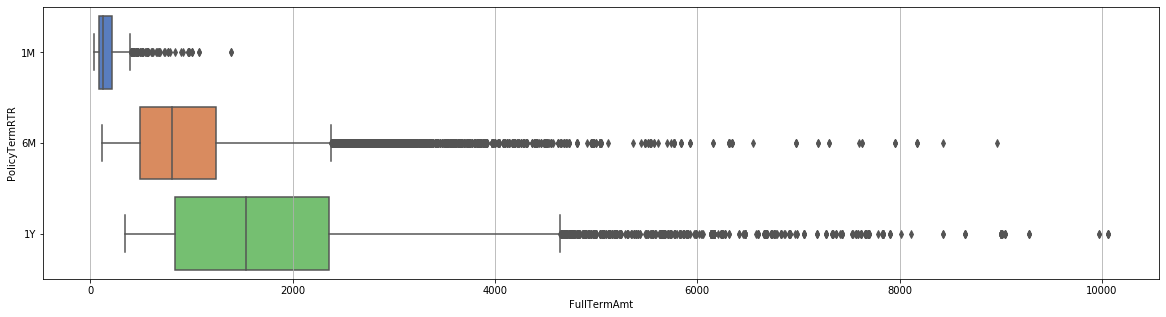

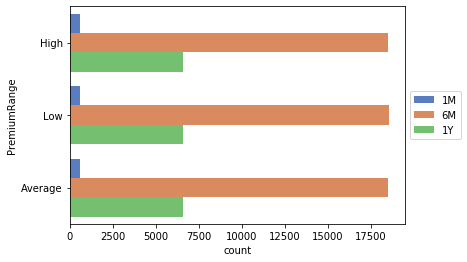

Shape of allData DataFrame after removing FullTermAmt row: (76946, 44)


In [42]:
# plot the FullTermAmt Value grouped by PolicyTermRTR
fig, axs = plt.subplots(figsize=(20,5))
ax = sns.boxplot(y="PolicyTermRTR", x="FullTermAmt", data=allData, order=["1M","6M","1Y"])
# Show the vertical gridlines
ax.xaxis.grid(True) 

# Transform FullTermAmt to a Premium Band after analysing distribution
bin_labels = ['Low','Average','High']
allData['PremiumRange'] = allData.groupby('PolicyTermRTR')['FullTermAmt'].transform(lambda x: pd.qcut(x,3,labels = bin_labels).astype(str))

fig, axs = plt.subplots()
ax = sns.countplot(data=allData, 
              y='PremiumRange',
              hue='PolicyTermRTR',
             hue_order=["1M","6M","1Y"])

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

allData = allData.drop(['FullTermAmt'], axis = 1) 

plt.show()

print("Shape of allData DataFrame after removing FullTermAmt row: " + str(allData.shape))

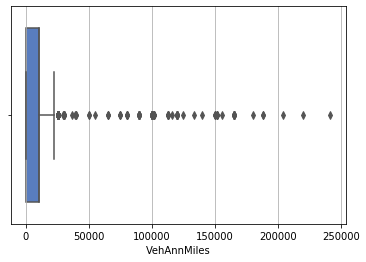

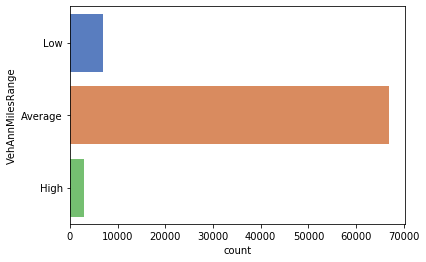

In [43]:
# Analysis the distribution of VehAnnMiles
fig, axs = plt.subplots()
ax = sns.boxplot(x="VehAnnMiles", data=allData)
# Show the vertical gridlines
ax.xaxis.grid(True) 

# Transform VehAnnMiles after analysis
# drop outliers
allData.drop( allData[ allData['VehAnnMiles'] > 100000 ].index , inplace=True)
# When VehAnnMiles is zero default to 12000
allData.loc[(allData.VehAnnMiles==0), 'VehAnnMiles'] = 12000

# define the bin labels and cuts
bin_labels = ['Low','Average','High']
cut_bins = [0,7499,14999,100000]

# Discretise the VehAnnMiles Field
allData['VehAnnMilesRange'] = pd.cut(allData['VehAnnMiles'],
                                   bins=cut_bins,
                                   labels = bin_labels)

# Drop VehAnnMiles as no longer needed
allData = allData.drop(['VehAnnMiles'], axis = 1) 

# show plots before and after discretisation
fig, axs = plt.subplots()
ax = sns.countplot(data=allData, y='VehAnnMilesRange')

plt.show()

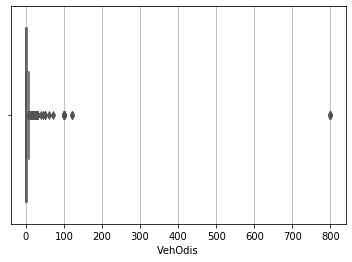

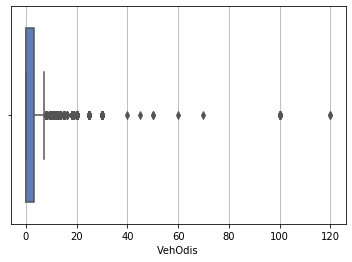

Shape of allData DataFrame after removing VehOdis row: (76892, 43)


In [44]:
# Analysis the distribution of VehAnnMiles
fig, axs = plt.subplots()
ax = sns.boxplot(x="VehOdis", data=allData)
# Show the vertical gridlines
ax.xaxis.grid(True)

# drop value 800 as there are only 6 values with this amount and next value is 120
allData.drop( allData[ allData['VehOdis'] == 800 ].index , inplace=True)

fig, axs = plt.subplots()
ax = sns.boxplot(x="VehOdis", data=allData)
# Show the vertical gridlines
ax.xaxis.grid(True)

plt.show()

#allData['VehOdis'].value_counts()
len(allData[ allData['VehOdis'] == 800 ])

# As there is 48926 rows where VehOdis is equal to zero going to drop the column
allData = allData.drop(['VehOdis'], axis = 1) 

print("Shape of allData DataFrame after removing VehOdis row: " + str(allData.shape))
   

In [45]:
#Merge DrvLicType and DrvLicTypeRater
allData.loc[(allData.DrvLicTypeRater == 'Driver') & (allData.DrvLicType == 'LI'), 'DrvLicTypeRater'] = "LICENSE"
allData.loc[(allData.DrvLicTypeRater == 'Driver') & (allData.DrvLicType == 'SUSPENDED'), 'DrvLicTypeRater'] = "SUSPENDED"
allData.drop( allData[ allData['DrvLicTypeRater'] == 'Driver' ].index , inplace=True)

# drop the DrvLicType field
allData = allData.drop(['DrvLicType'], axis = 1) 

print("Shape of allData DataFrame after removing DrvLicType row: " + str(allData.shape))

Shape of allData DataFrame after removing DrvLicType row: (76723, 42)


In [46]:
# Create a new field, if DrvLicJur is different to State, then it is an out of state licence
allData['OutOfStateLicense'] = np.where(allData['DrvLicJur']==allData['State'], 'N', 'Y')
allData['GaragedOutOfState'] = np.where(allData['VehState']==allData['State'], 'N', 'Y')

allData = allData.drop(['DrvLicJur','VehState'], axis = 1) 

In [47]:
# TransDateTime - records the date the data was generated.  Transforming this to day of week
allData['TransDateTime'] = pd.to_datetime(allData['TransDateTime'])

allData['TransDayOfWeek'] = allData['TransDateTime'].dt.day_name()
allData = allData.drop('TransDateTime', axis = 1) 

In [48]:
printCountUniqueValesPerColumn(allData)

                   Count
OutOfStateLicense      2
DrvSex                 2
VehCustMod             2
DrvGoodStudent         2
QuoteBound             2
QuoteUploaded          2
GaragedOutOfState      2
VehABS                 3
PolicyTermRTR          3
PremiumRange           3
VehAnnMilesRange       3
DrvSWLicStatus         4
MPCoverageRTR          5
RTCoverageRTR          5
VehNo                  6
VehRatedOperator       6
VehUse                 6
DrvMar                 6
DrvEmployStatus        6
DrvNo                  6
DrvLicTypeRater        7
DrvRelationship        7
TransDayOfWeek         7
UMCoverageRTR          7
BICoverageRTR          9
State                 10
CLCoverageRTR         11
CPCoverageRTR         11
DrvAgeBand            13
VehAgeBand            30
VehMake               51
EffectiveDate        271
County               456
VehSymbolRaterNum   1221
VehCityFirst        1996
VehCity             1996
City                2002
VehModel            3101
VehPostalCode       3187


In [49]:
# due to domain knowledge of the fields and high cardionality of some of the fields - decided to drop the following columns.
listOfColumnsToDrop = ['EffectiveDate','VehSymbolRaterNum','PostalCode','City','VehCity','VehPostalCode','VehCityFirst',
                       #drop ID Fields also
                       'FileName','RTRRefNo']

for col in listOfColumnsToDrop:  
    if col in allData.columns :
        allData.drop([col] , axis='columns', inplace=True)
    else :
        print('Column ' + col + ' Name not found')   
        
print("Shape of allData DataFrame after removing various rows is: " + str(allData.shape))

Shape of allData DataFrame after removing various rows is: (76723, 33)


## Part 4 Exploratory Data Analysis and Feature Engineering
<div class="alert alert-block alert-info">
    I carried out some further analysis of dataset in order to find trends and relationships between variables in the data.    
    Also performed some feature reduction techniques
</div>

In [50]:
# import libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.pipeline import Pipeline, make_pipeline
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.metrics import auc, roc_curve, precision_score, confusion_matrix, roc_auc_score
from sklearn.metrics import recall_score, f1_score,accuracy_score, plot_confusion_matrix, precision_score

from scipy.stats import randint, uniform

### Exploratory Data Analysis (EDA)

In [51]:
# function to add the percentage value to top of each bar in count plot
# Ref: https://stackoverflow.com/questions/31749448/how-to-add-percentages-on-top-of-bars-in-seaborn
def addPercentageToBar(ax):
    ax.set_ylabel('')

    bars = ax.patches
    half = int(len(bars)/2)
    left_bars = bars[:half]
    right_bars = bars[half:]

    for left, right in zip(left_bars, right_bars):
        height_l = left.get_height()
        height_r = right.get_height()
        total = height_l + height_r

        ax.text(left.get_x() + left.get_width()/2., height_l + 40, '{0:.0%}'.format(height_l/total), ha="center")
        ax.text(right.get_x() + right.get_width()/2., height_r + 40, '{0:.0%}'.format(height_r/total), ha="center")
        

In [52]:
# Ref: https://towardsdatascience.com/machine-learning-classifiers-comparison-with-python-33149aecdbca
# make copy of data in order to carry out the EDA
df1 = allData.copy()

# changed the type of data in order to do the analysis
df1['DrvAgeBand'] = df1['DrvAgeBand'].astype('object')
df1['VehAnnMilesRange'] = df1['VehAnnMilesRange'].astype('object')
df1['VehAgeBand'] = df1['VehAgeBand'].astype('int32')
df1['VehAgeBand'] = df1['VehAgeBand'].astype('object')


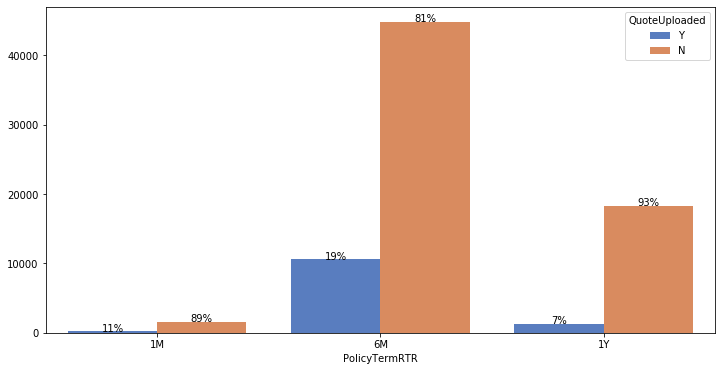

In [53]:
# Countplot of PolicyTermRTR showing QuoteUploaded breakdown
plt.figure(figsize=(12,6))
ax1 = sns.countplot("PolicyTermRTR", data=df1, hue="QuoteUploaded", order=["1M","6M","1Y"])
# add percentage breakdown of QuoteUploaded for each PolicyTermRTR category 
addPercentageToBar(ax1)

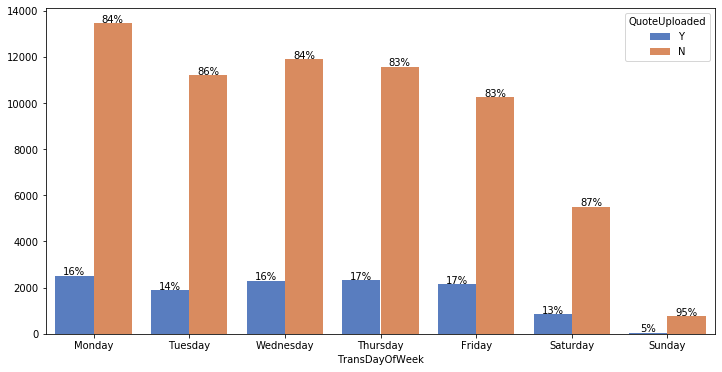

In [54]:
# Countplot of TransDayOfWeek showing QuoteUploaded breakdown
plt.figure(figsize=(12,6))
ax2 = sns.countplot("TransDayOfWeek", data=df1, hue="QuoteUploaded",  
                   order=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
# add percentage breakdown of QuoteUploaded for each TransDayOfWeek category 
addPercentageToBar(ax2)

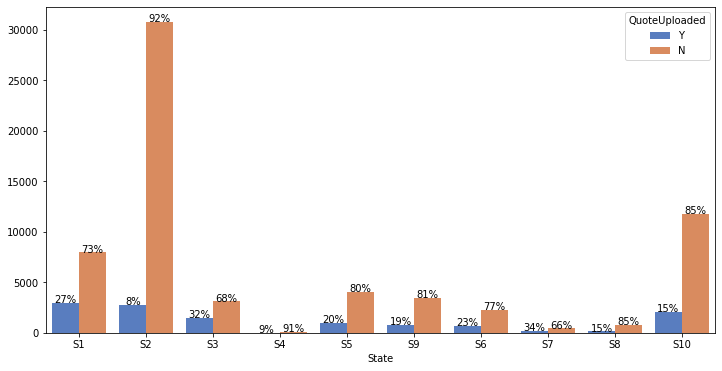

In [58]:
# Countplot of State showing QuoteUploaded breakdown
# Note: the State field has been anonymised for business sensitivity reasons.
plt.figure(figsize=(12,6))
ax3 = sns.countplot("State", data=df1, hue="QuoteUploaded")
# add percentage breakdown of QuoteUploaded for State category 
addPercentageToBar(ax3)

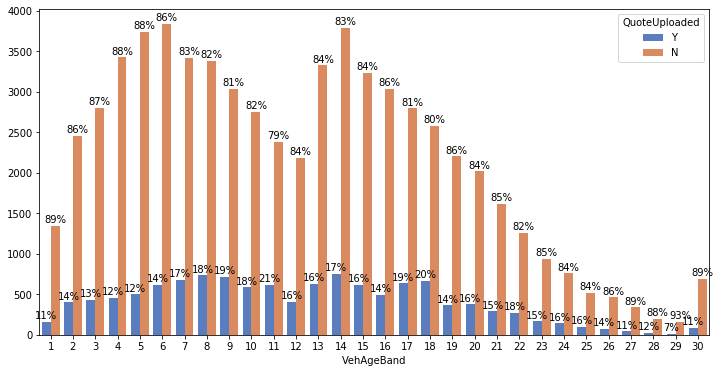

In [59]:
# Countplot of VehAgeBand showing QuoteUploaded breakdown
plt.figure(figsize=(12,6))
ax4 = sns.countplot("VehAgeBand", data=df1, hue="QuoteUploaded")
# add percentage breakdown of QuoteUploaded for VehAgeBand category 
addPercentageToBar(ax4)

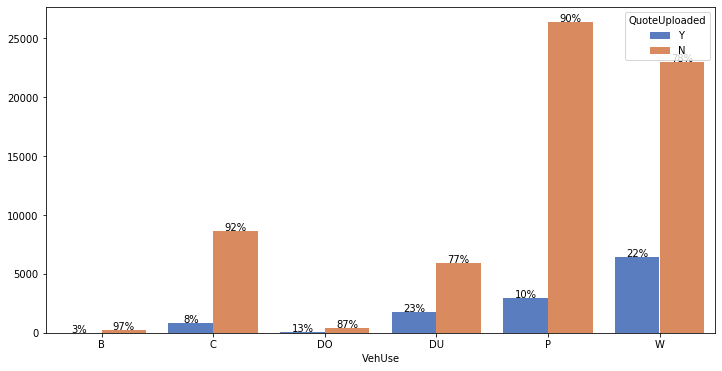

In [60]:
# Countplot of VehUse showing QuoteUploaded breakdown
plt.figure(figsize=(12,6))
ax5 = sns.countplot("VehUse", data=df1, hue="QuoteUploaded", order=["B","C","DO","DU","P","W"])
# add percentage breakdown of QuoteUploaded for VehUse category 
addPercentageToBar(ax5)

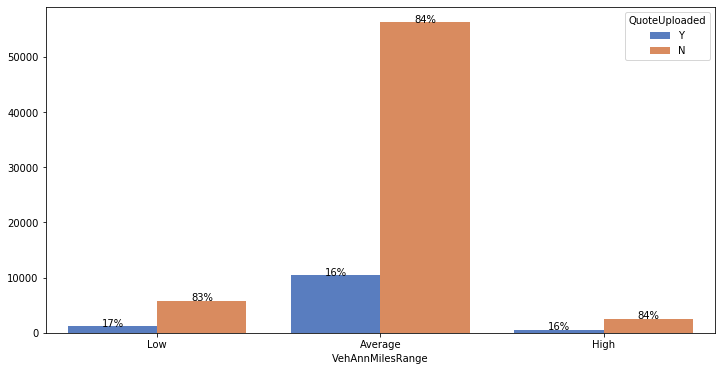

In [61]:
# Countplot of VehAnnMilesRange showing QuoteUploaded breakdown
plt.figure(figsize=(12,6))
ax6 = sns.countplot("VehAnnMilesRange", data=df1, hue="QuoteUploaded", order=["Low","Average","High"])
# add percentage breakdown of QuoteUploaded for VehAnnMilesRange category 
addPercentageToBar(ax6)

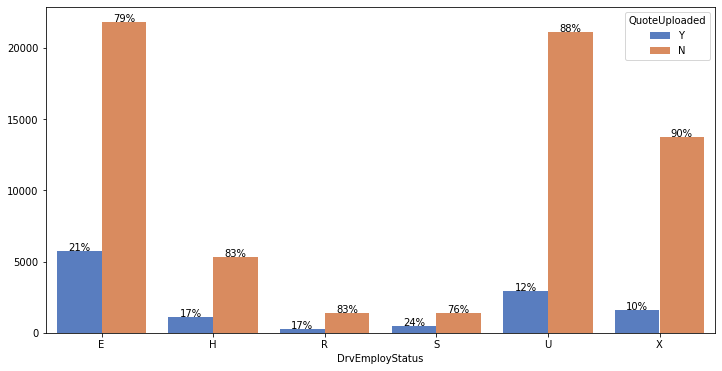

In [62]:
# Countplot of DrvEmployStatus showing QuoteUploaded breakdown
plt.figure(figsize=(12,6))
ax7 = sns.countplot("DrvEmployStatus", data=df1, hue="QuoteUploaded", order=["E","H","R","S","U","X"])
# add percentage breakdown of QuoteUploaded for VehAnnMilesRange category 
addPercentageToBar(ax7)

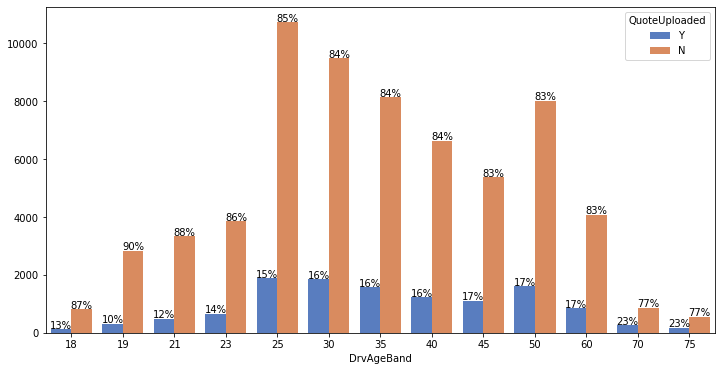

In [63]:
# Countplot of DrvAgeBand showing QuoteUploaded breakdown
plt.figure(figsize=(12,6))
ax8 = sns.countplot("DrvAgeBand", data=df1, hue="QuoteUploaded")
# add percentage breakdown of DrvAgeBand for VehAnnMilesRange category 
addPercentageToBar(ax8)

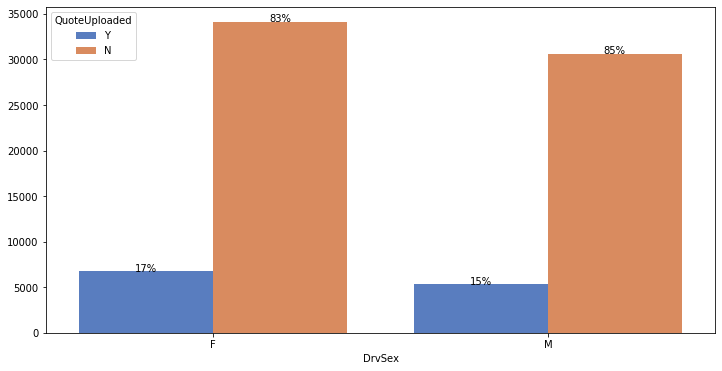

In [64]:
# Countplot of DrvSex showing QuoteUploaded breakdown
plt.figure(figsize=(12,6))
ax9 = sns.countplot("DrvSex", data=df1, hue="QuoteUploaded", order=["F","M"])
# add percentage breakdown of DrvSex for VehAnnMilesRange category 
addPercentageToBar(ax9)

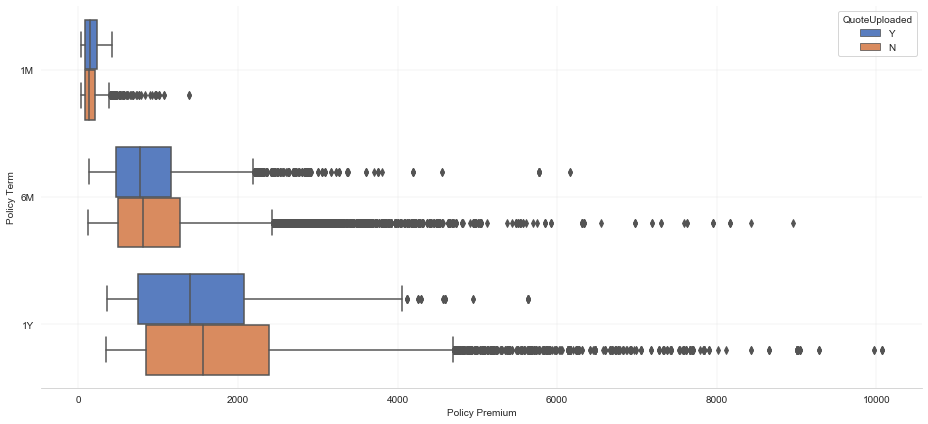

In [51]:
# boxplot of the fullTermAmt by PolicyTermRTR category (before transformation of this variable)
sns.set_style("whitegrid")
g = sns.catplot(y="PolicyTermRTR", x="FullTermAmt", hue="QuoteUploaded", data=dfB4Transform, 
                height=6, kind="box", palette="muted", aspect=13/6, order=["1M","6M","1Y"], legend_out=False)
g.despine(left=True)
g.set_xlabels("Policy Premium")
g.set_ylabels("Policy Term")
plt.grid(linewidth=0.2)
ax.patch.set_edgecolor('black')  
plt.show()


### Feature Reduction and Selection

In [32]:
df = allData.copy()

# reset datatypes in order to perform label encoding
df['DrvAgeBand'] = df['DrvAgeBand'].astype('object')
df['VehAnnMilesRange'] = df['VehAnnMilesRange'].astype('object')
df['VehAgeBand'] = df['VehAgeBand'].astype('object')

# get list and print list of categorical columns
categorical_cols = list(df.select_dtypes('object').columns)
print(categorical_cols)

# instantiate labelencoder object
le = LabelEncoder()

# apply label encoding to categorical feature columns
df[categorical_cols] = df[categorical_cols].apply(lambda col: le.fit_transform(col))


['BICoverageRTR', 'UMCoverageRTR', 'MPCoverageRTR', 'County', 'State', 'PolicyTermRTR', 'VehMake', 'VehModel', 'VehUse', 'VehCustMod', 'CPCoverageRTR', 'CLCoverageRTR', 'RTCoverageRTR', 'VehABS', 'DrvSex', 'DrvMar', 'DrvGoodStudent', 'DrvSWLicStatus', 'DrvLicTypeRater', 'DrvEmployStatus', 'DrvRelationship', 'QuoteUploaded', 'QuoteBound', 'DrvAgeBand', 'VehAgeBand', 'PremiumRange', 'VehAnnMilesRange', 'OutOfStateLicense', 'GaragedOutOfState', 'TransDateOfWeek']


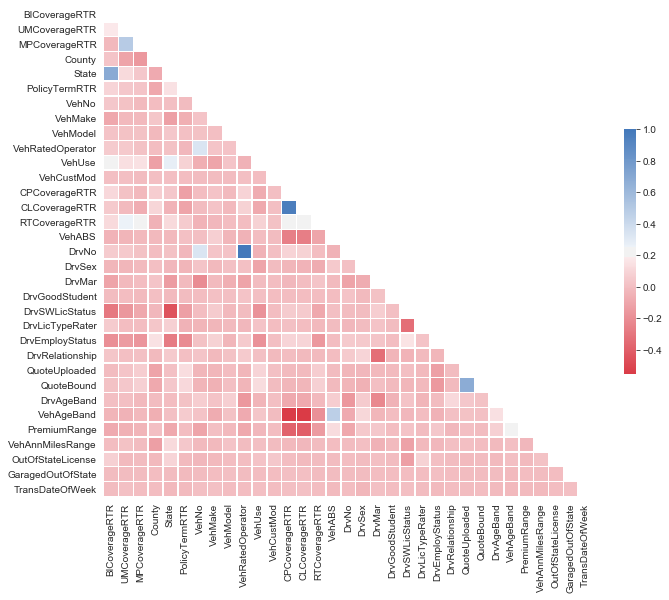

In [131]:
# use the pandas .corr() function to compute pairwise correlations for the dataframe
corr = df.corr()
# visualise the data with seaborn
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.set_style(style = 'white')
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(10, 250, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, 
        square=True,
        linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

plt.show()


In [132]:
# drop the following columns based on analysis of the correlation plot above.
df = df.drop(['CLCoverageRTR','CPCoverageRTR','DrvNo'], axis = 1) 

print("Shape of DataFrame after removing various rows is: " + str(df.shape))

df.to_csv('df.csv')  


Shape of DataFrame after removing various rows is: (76723, 30)


In [133]:
# get the dataset and set up scoring 
def get_dataset(data):
    y = data.QuoteUploaded
    X = data.drop('QuoteUploaded', axis=1)
    return X, y


# set up scoring type for analysis - ROC AUC Scoring
scoringType = 'roc_auc'

# split data into test/training 75/25 split
X, y = get_dataset(df)
X_train, X_test, y_train, y_test= train_test_split(X, y,                                                    
                                                   test_size=0.25,
                                                   random_state=0)

### Logistic Regression Feature Selection

For this section the results are not reproducable - slightly different results are returned every time this feature selection section is run.  So please note that the number of features returned might not match the number of features in the thesis.  The results for one particular run was saved to csv files and then reloaded for the later parts of this notebook. 
All other sections of this code are reproducable by using random_state parameter.


Best combination (ACC: 0.821): (0, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 26, 27)

Index(['BICoverageRTR', 'County', 'State', 'PolicyTermRTR', 'VehNo',
       'VehModel', 'VehRatedOperator', 'VehUse', 'VehCustMod', 'RTCoverageRTR',
       'DrvSex', 'DrvMar', 'DrvGoodStudent', 'DrvSWLicStatus',
       'DrvLicTypeRater', 'DrvEmployStatus', 'DrvRelationship', 'QuoteBound',
       'DrvAgeBand', 'PremiumRange', 'OutOfStateLicense', 'GaragedOutOfState'],
      dtype='object')


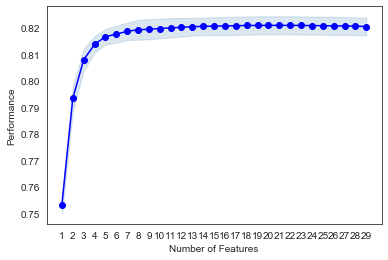

Wall time: 45min 43s


In [134]:
%%time

#Source: http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/
lr = LogisticRegression(random_state = 0, penalty = 'l1', solver='saga',max_iter=1000)

# set up the sequential feature selector, with logistic regression estimator. Used forward selection. 
sfs1 = SFS(estimator=lr, 
           k_features=(3, 29),
           forward=True, 
           floating=False, 
           scoring=scoringType,
           cv=5,
           n_jobs=-1)

# create pipeline of standard scalar and sequential feature selector
pipe = make_pipeline(StandardScaler(), sfs1)

# fit the model
pipe.fit(X_train, y_train)

# print and plot the best combination of features that return highest ROC_AUC Score
print('Best combination (ACC: %.3f): %s\n' % (sfs1.k_score_, sfs1.k_feature_idx_))
cols = list(sfs1.k_feature_idx_)
featuresLR = X.columns[cols]
print(featuresLR)
plot_sfs(sfs1.get_metric_dict(), kind='std_err');
plt.show()


In [135]:
# make a copy of dataset
featuresListLR = featuresLR.tolist()
dfLR = df.copy()
# Drop the columns based on forward feature selection above 
dfLR.drop(dfLR.columns.difference(featuresListLR), 1, inplace=True)
print(dfLR.shape)
#dfLR.to_csv('dfLR.csv')


(76723, 22)


### Random Forest Feature Selection

Best combination (ACC: 0.977): (0, 1, 2, 3, 4, 7, 8, 10, 11, 13, 14, 15, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28)

Index(['BICoverageRTR', 'UMCoverageRTR', 'MPCoverageRTR', 'County', 'State',
       'VehMake', 'VehModel', 'VehUse', 'VehCustMod', 'VehABS', 'DrvSex',
       'DrvMar', 'DrvSWLicStatus', 'DrvLicTypeRater', 'DrvEmployStatus',
       'QuoteBound', 'DrvAgeBand', 'VehAgeBand', 'PremiumRange',
       'VehAnnMilesRange', 'OutOfStateLicense', 'GaragedOutOfState',
       'TransDateOfWeek'],
      dtype='object')


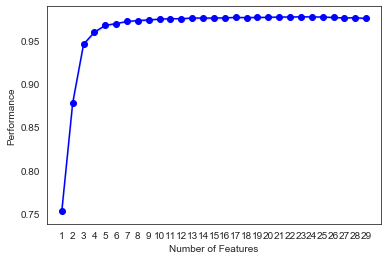

Wall time: 20min 25s


In [136]:
%%time
# Repeat feature selector on Random Forest classifier
rf = RandomForestClassifier(random_state=0, n_jobs=-1)

# set up the sequential feature selector, with random forest estimator. Used forward selection. 
sfs2 = SFS(estimator=rf, 
           k_features=(3, 29),
           forward=True, 
           floating=False, 
           scoring=scoringType,
           cv=5,
           n_jobs=-1)

# fit the model
sfs2.fit(X_train, y_train)

# print and plot the best combination of features that return highest ROC_AUC Score
print('Best combination (ACC: %.3f): %s\n' % (sfs2.k_score_, sfs2.k_feature_idx_))
cols2 = list(sfs2.k_feature_idx_)
featuresrf = X.columns[cols2]
print(featuresrf)
plot_sfs(sfs2.get_metric_dict(), kind='std_err');

plt.show()

In [137]:
# make a copy of dataset
featuresListRF = featuresrf.tolist()
dfRF = df.copy()
# Drop the columns based on forward feature selection above 
dfRF.drop(dfRF.columns.difference(featuresListRF), 1, inplace=True)
print(dfRF.shape)

#dfRF.to_csv('dfRF.csv')

(76723, 23)


### K Nearest Neighbour Feature Selection

Best combination (ACC: 0.944): (3, 4, 7, 8, 11, 16, 17, 18, 19, 21, 22, 23, 25, 27)

Index(['County', 'State', 'VehMake', 'VehModel', 'VehCustMod',
       'DrvGoodStudent', 'DrvSWLicStatus', 'DrvLicTypeRater',
       'DrvEmployStatus', 'QuoteBound', 'DrvAgeBand', 'VehAgeBand',
       'VehAnnMilesRange', 'GaragedOutOfState'],
      dtype='object')


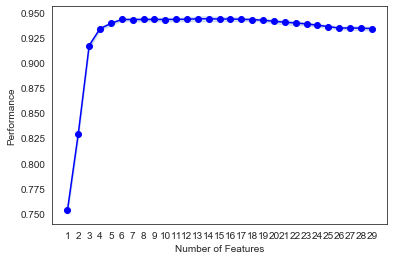

Wall time: 1h 15min 40s


In [138]:
%%time

# Repeat feature selector on  K Nearest Neighbour Classifier
knn = KNeighborsClassifier(n_jobs=-1)  

# set up the sequential feature selector, with random forest estimator. Used forward selection. 
sfs3 = SFS(estimator=knn, 
           k_features=(3, 29),
           forward=True, 
           floating=False, 
           scoring=scoringType,
           cv=5,
           n_jobs=-1)

# create pipeline of standard scalar and sequential feature selector
pipe3 = make_pipeline(StandardScaler(), sfs3)

# fit model
pipe3.fit(X_train, y_train)

# print and plot the best combination of features that return highest ROC_AUC Score
print('Best combination (ACC: %.3f): %s\n' % (sfs3.k_score_, sfs3.k_feature_idx_))
cols3 = list(sfs3.k_feature_idx_)
featuresKNN = X.columns[cols3]
print(featuresKNN)
plot_sfs(sfs3.get_metric_dict(), kind='std_err');

plt.show()

In [139]:
# make a copy of dataset
featuresListKNN = featuresKNN.tolist()
dfKNN = df.copy()
print(len(featuresListKNN))
# Drop the columns based on forward feature selection above 
dfKNN.drop(dfKNN.columns.difference(featuresListKNN), 1, inplace=True)
print(dfKNN.shape)

#dfKNN.to_csv('dfKNN1.csv')

14
(76723, 14)


### XGBoost Classifier Feature Selection

Best combination (ACC: 0.958): (0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 14, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28)

Index(['BICoverageRTR', 'UMCoverageRTR', 'MPCoverageRTR', 'County', 'State',
       'PolicyTermRTR', 'VehMake', 'VehModel', 'VehRatedOperator', 'VehUse',
       'VehCustMod', 'DrvSex', 'DrvGoodStudent', 'DrvSWLicStatus',
       'DrvLicTypeRater', 'DrvEmployStatus', 'QuoteBound', 'DrvAgeBand',
       'VehAgeBand', 'PremiumRange', 'VehAnnMilesRange', 'OutOfStateLicense',
       'GaragedOutOfState', 'TransDateOfWeek'],
      dtype='object')


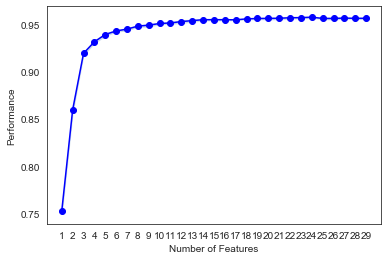

Wall time: 23min 58s


In [140]:
%%time
# Repeat feature selector on  XGBoost Classifier
xgb = XGBClassifier(random_state=0, n_jobs=-1)

# set up the sequential feature selector, with random forest estimator. Used forward selection. 
sfs5 = SFS(estimator=xgb, 
           k_features=(3, 29),
           forward=True, 
           floating=False, 
           scoring=scoringType,
           cv=5,
           n_jobs=-1)

# fit the model
sfs5.fit(X_train, y_train)

# print and plot the best combination of features that return highest ROC_AUC Score
print('Best combination (ACC: %.3f): %s\n' % (sfs5.k_score_, sfs5.k_feature_idx_))
cols5 = list(sfs5.k_feature_idx_)
featuresXGB = X.columns[cols5]
print(featuresXGB)
plot_sfs(sfs5.get_metric_dict(), kind='std_err');

plt.show()

In [141]:
# make a copy of dataset
featuresListXGB = featuresXGB.tolist()
dfXGB = df.copy()
print(len(featuresListXGB))
# Drop the columns based on forward feature selection above 
dfXGB.drop(dfXGB.columns.difference(featuresListXGB), 1, inplace=True)
print(dfXGB.shape)

#dfXGB.to_csv('dfXGB1.csv')

24
(76723, 24)


## Part 5  Imbalanced Data Investigation
<div class="alert alert-block alert-info">
    Data to classifiy is imbalanced. Try different techniques to handle this imbalance.
</div>

In [36]:
# function to print classifier results,.
def printClassiferResults(descOfRun, y_test, y_pred, cv_score, scoringType ):
    print(descOfRun)

    print("=== Confusion Matrix ===")
    print(confusion_matrix(y_test, y_pred))

    print("=== Cross Validation Score ===")        
    print("Mean " + scoringType + " Score: " + str(cv_score.mean()))
    
    print("=== Test Data Score ===") 
    if scoringType == "f1":
        score = f1_score(y_test, y_pred)    
    elif scoringType == "roc_auc":
        score = roc_auc_score(y_test, y_pred)    
    elif scoringType == "recall":
        score = recall_score(y_test, y_pred)
    print("Test " + scoringType + " Score: " + str(score))
    print('\n')

(76723, 30)
No of rows where QuoteUploaded is Y: 12059 (15.72% )
No of rows where QuoteUploaded is N: 64664 (84.28% )


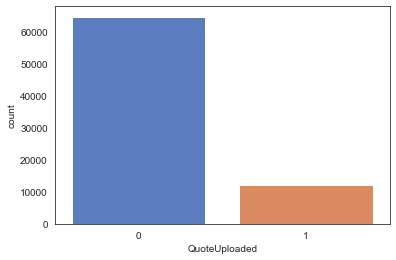

In [37]:
print(df.shape)
noOfRows = len(df.index)
noUploaded = df[df.QuoteUploaded == 1].shape[0]
noNotUploaded = df[df.QuoteUploaded == 0].shape[0]
print("No of rows where QuoteUploaded is Y: " + str(noUploaded) + " (" + str(round((noUploaded/noOfRows)*100,2)) + "% )") 
print("No of rows where QuoteUploaded is N: " + str(noNotUploaded) + " (" + str(round((noNotUploaded/noOfRows)*100,2)) + "% )") 
#Visualize the count of QuoteUploaded
sns.countplot(df['QuoteUploaded'])
plt.show()

### Logistic Regression Sampling

In [38]:
# get dataset
X, y = get_dataset(df)
# use 5-fold cross validation
kf = KFold(n_splits=5, random_state=0, shuffle=True)


In [39]:
%%time
#Compare balancing techniques  (Logistic Regression)
print(df.shape)
# split data into test/train set 75/25 split.
X_train, X_test, y_train, y_test= train_test_split(X, y,                                                    
                                                   test_size=0.25,
                                                   random_state=0)
sc = StandardScaler()
lr = LogisticRegression(random_state = 0, solver='saga',max_iter=5000)

######  Run of Logistic Regression with full dataset #####################
# create pipline of standard scaler and logistic regression model
pipe = make_pipeline(sc, lr)
# fit model
pipe.fit(X_train, y_train)
# make prediction using test data
y_pred = pipe.predict(X_test)
# get the cross validation score
cv_score = cross_val_score(pipe, X_train, y_train, scoring=scoringType, cv=kf)
# print results
printClassiferResults('Run of Logistic Regression with full dataset', y_test, y_pred,cv_score,scoringType)

######  Run of Logistic Regression with reduced dataset #####################
dfLR = pd.read_csv("dfLR.csv", index_col=[0]) 
print(dfLR.shape)
# use reduced dataset
X = dfLR
# split data 
X_train, X_test, y_train, y_test= train_test_split(X, y,                                                    
                                                   test_size=0.25,
                                                   random_state=0)
# create pipline of standard scaler and logistic regression model
pipe = make_pipeline(sc, lr)
# fit model
pipe.fit(X_train, y_train)
# make prediction using test data
y_pred = pipe.predict(X_test)
# get the cross validation score
cv_score = cross_val_score(pipe, X_train, y_train, scoring=scoringType, cv=kf)
# print results
printClassiferResults('Run of Logistic Regression with reduced dataset', y_test, y_pred,cv_score,scoringType)

######  Run of Logistic Regression with oversampling on reduced dataset #####################
ros = RandomOverSampler(random_state=0)
# create pipeline of standardscalar, random over sampler and logistic regression model
pipe = make_pipeline(sc, ros, lr)
# fit model
pipe.fit(X_train, y_train)
# make prediction using test data
y_pred = pipe.predict(X_test)
# get the cross validation scores
cv_score = cross_val_score(pipe, X_train, y_train, scoring=scoringType, cv=kf)
# print results
printClassiferResults('Run of Logistic Regression with reduced dataset (oversample)', y_test, y_pred,cv_score,scoringType)

######  Run of Logistic Regression with balanced class weight on reduced dataset #####################
lr = LogisticRegression(random_state = 0, solver='saga',class_weight='balanced',max_iter=5000)
# make pipeline of standard scalar and logistic regression using balanced class weight
pipe = make_pipeline(sc, lr)
# fit model
pipe.fit(X_train, y_train)
# make prediction using test data
y_pred = pipe.predict(X_test)
# get the cross validation score
cv_score = cross_val_score(pipe, X_train, y_train, scoring=scoringType, cv=kf)
# print results
printClassiferResults('Run of Logistic Regression with reduced dataset (class_weight=Balanced)', y_test, y_pred,cv_score,scoringType)

######  Run of Logistic Regression with reduced dataset (SMOTE) #####################
lr = LogisticRegression(random_state = 0, solver='saga',max_iter=5000)
smt = SMOTE(random_state=0,n_jobs=-1)
# make pipeline of standard scalar and smote sampling and logistic regression model
pipe = make_pipeline(sc,smt, lr)
# fit model
pipe.fit(X_train, y_train)
# make prediction using test data
y_pred = pipe.predict(X_test)
# get cross validation score
cv_score = cross_val_score(pipe, X_train, y_train, scoring=scoringType, cv=kf)
# print results
printClassiferResults('Run of Logistic Regression with reduced dataset (SMOTE)', y_test, y_pred,cv_score,scoringType)

(76723, 30)
Run of Logistic Regression with full dataset
=== Confusion Matrix ===
[[16145     0]
 [ 1506  1530]]
=== Cross Validation Score ===
Mean roc_auc Score: 0.8208747102066158
=== Test Data Score ===
Test roc_auc Score: 0.7519762845849802


(76723, 21)
Run of Logistic Regression with reduced dataset
=== Confusion Matrix ===
[[16145     0]
 [ 1506  1530]]
=== Cross Validation Score ===
Mean roc_auc Score: 0.8214563178222234
=== Test Data Score ===
Test roc_auc Score: 0.7519762845849802


Run of Logistic Regression with reduced dataset (oversample)
=== Confusion Matrix ===
[[15433   712]
 [ 1387  1649]]
=== Cross Validation Score ===
Mean roc_auc Score: 0.82154899934968
=== Test Data Score ===
Test roc_auc Score: 0.749524269721329


Run of Logistic Regression with reduced dataset (class_weight=Balanced)
=== Confusion Matrix ===
[[15412   733]
 [ 1357  1679]]
=== Cross Validation Score ===
Mean roc_auc Score: 0.8216836690904425
=== Test Data Score ===
Test roc_auc Score: 0.75381462

### Random Forest Sampling

In [40]:
%%time
#Compare balancing techniques  (Random Forest)
print(df.shape)
# get dataset
X, y = get_dataset(df)
# split data set into test/train
X_train, X_test, y_train, y_test= train_test_split(X, y,                                                    
                                                   test_size=0.25,
                                                   random_state=0)
rf = RandomForestClassifier(random_state=0,n_jobs=-1)

######  Run of Random Forest with full dataset #####################
#fit model
rf.fit(X_train, y_train)
# make predictions using test data
y_pred = rf.predict(X_test)
# get cross validation scores
cv_score = cross_val_score(rf, X_train, y_train, scoring=scoringType, cv=kf)
# print results
printClassiferResults('Run of Random Forest with full dataset', y_test, y_pred,cv_score,scoringType)

######  Run of Random Forest with reduced dataset #####################
dfRF = pd.read_csv("dfRF.csv", index_col=[0]) 
print(dfRF.shape)
# get reduced random forest dataset
X = dfRF
# split data 
X_train, X_test, y_train, y_test= train_test_split(X, y,                                                    
                                                   test_size=0.25,
                                                   random_state=0)
# fit model 
rf.fit(X_train, y_train)
# make prediction using test data
y_pred = rf.predict(X_test)
# get cross validation scores
cv_score = cross_val_score(rf, X_train, y_train, scoring=scoringType, cv=kf)
printClassiferResults('Run of Random Forest with reduced dataset', y_test, y_pred,cv_score,scoringType)

######  Run of Random Forest with oversampling on reduced dataset #####################
ros = RandomOverSampler(random_state=0)
# make pipeline of random over sampler and random forest model
pipe = make_pipeline(ros, rf)
# run model
pipe.fit(X_train, y_train)
# make predictions using test data
y_pred = pipe.predict(X_test)
# get cross validation scores
cv_score = cross_val_score(pipe, X_train, y_train, scoring=scoringType, cv=kf)
# print results
printClassiferResults('Run of Random Forest with reduced dataset (oversample)', y_test, y_pred,cv_score,scoringType)

######  Run of Random Forest with balanced class weight on reduced dataset #####################
rf = RandomForestClassifier(random_state=0, class_weight='balanced',n_jobs=-1)
# run model
rf.fit(X_train, y_train)
# make predictions using test data
y_pred = rf.predict(X_test)
# get cross validation scores
cv_score = cross_val_score(pipe, X_train, y_train, scoring=scoringType, cv=kf)
# print results
printClassiferResults('Run of Random Forest with reduced dataset (class_weight=Balanced)', y_test, y_pred,cv_score,scoringType)

######  Run of Random Forest with reduced dataset (SMOTE) #####################
rf = RandomForestClassifier(random_state=0,n_jobs=-1)
smt = SMOTE(random_state=0,n_jobs=-1)
# make pipeline of smote sampler and random forest model
pipe = make_pipeline(smt, rf)
# run model
pipe.fit(X_train, y_train)
# make predictions using test data
y_pred = pipe.predict(X_test)
# get cross validation results
cv_score = cross_val_score(pipe, X_train, y_train, scoring=scoringType, cv=kf)
# print results
printClassiferResults('Run of Random Forest with reduced dataset (SMOTE)', y_test, y_pred,cv_score,scoringType)


(76723, 30)
Run of Random Forest with full dataset
=== Confusion Matrix ===
[[15994   151]
 [  358  2678]]
=== Cross Validation Score ===
Mean roc_auc Score: 0.9729381359324483
=== Test Data Score ===
Test roc_auc Score: 0.9363644728214456


(76723, 25)
Run of Random Forest with reduced dataset
=== Confusion Matrix ===
[[15989   156]
 [  344  2692]]
=== Cross Validation Score ===
Mean roc_auc Score: 0.9743590696711418
=== Test Data Score ===
Test roc_auc Score: 0.938515291468824


Run of Random Forest with reduced dataset (oversample)
=== Confusion Matrix ===
[[15953   192]
 [  272  2764]]
=== Cross Validation Score ===
Mean roc_auc Score: 0.9730715630906275
=== Test Data Score ===
Test roc_auc Score: 0.9492581027259955


Run of Random Forest with reduced dataset (class_weight=Balanced)
=== Confusion Matrix ===
[[15982   163]
 [  306  2730]]
=== Cross Validation Score ===
Mean roc_auc Score: 0.9730715517121442
=== Test Data Score ===
Test roc_auc Score: 0.9445567406054567


Run of Rand

### K Nearest Neighbours Sampling

In [41]:
%%time
# get dataset
X, y = get_dataset(df)
print(df.shape)
X_train, X_test, y_train, y_test= train_test_split(X, y,                                                    
                                                   test_size=0.25,
                                                   random_state=0)
knn = KNeighborsClassifier(n_jobs=-1)  
######  Run of  K Nearest Neighbours with full dataset #####################
# run model
knn.fit(X_train, y_train)
# make predictions using test data
y_pred = knn.predict(X_test)
# get cross validation scores
cv_score = cross_val_score(knn, X_train, y_train, scoring=scoringType, cv=kf)
# print results
printClassiferResults('Run of  K Nearest Neighbours with full dataset', y_test, y_pred,cv_score,scoringType)

######  Run of  K Nearest Neighbours with reduced dataset #####################
dfKNN = pd.read_csv("dfKNN.csv", index_col=[0]) 
# get reduced knn dataset
X = dfKNN
print(dfKNN.shape)
X_train, X_test, y_train, y_test= train_test_split(X, y,                                                    
                                                   test_size=0.25,
                                                   random_state=0)
# run model
knn.fit(X_train, y_train)
# make predictions using test data
y_pred = knn.predict(X_test)
# get cross validaiton results
cv_score = cross_val_score(pipe, X_train, y_train, scoring=scoringType, cv=kf)
# print results
printClassiferResults('Run of  K Nearest Neighbours with reduced dataset', y_test, y_pred,cv_score,scoringType)

######  Run of  K Nearest Neighbourst with oversampling on reduced dataset #####################
ros = RandomOverSampler(random_state=0)
# make pipeline of random over sampler and knn model
pipe = make_pipeline(ros, knn)
# run model pipeline
pipe.fit(X_train, y_train)
# make predictions using test data
y_pred = pipe.predict(X_test)
# get cross validation scores
cv_score = cross_val_score(pipe, X_train, y_train, scoring=scoringType, cv=kf)
# print results
printClassiferResults('Run of K Nearest Neighbours with reduced dataset (oversample)', y_test, y_pred,cv_score,scoringType)

######  Run of  K Nearest Neighbours with reduced dataset (SMOTE) #####################
smt = SMOTE(random_state=0,n_jobs=-1)
# make pipeline of smote sampler and knn
pipe = make_pipeline(smt, knn)
# run model pipeline
pipe.fit(X_train, y_train)
# make predictions using test data
y_pred = pipe.predict(X_test)
# get cross validation scores
cv_score = cross_val_score(pipe, X_train, y_train, scoring=scoringType, cv=kf)
# print results
printClassiferResults('Run of  K Nearest Neighbours with reduced dataset (SMOTE)', y_test, y_pred,cv_score,scoringType)

(76723, 30)
Run of  K Nearest Neighbours with full dataset
=== Confusion Matrix ===
[[15265   880]
 [ 1216  1820]]
=== Cross Validation Score ===
Mean roc_auc Score: 0.8621189312902633
=== Test Data Score ===
Test roc_auc Score: 0.7724834758779848


(76723, 13)
Run of  K Nearest Neighbours with reduced dataset
=== Confusion Matrix ===
[[15261   884]
 [ 1218  1818]]
=== Cross Validation Score ===
Mean roc_auc Score: 0.97102553380403
=== Test Data Score ===
Test roc_auc Score: 0.7720302177524093


Run of K Nearest Neighbours with reduced dataset (oversample)
=== Confusion Matrix ===
[[13819  2326]
 [  415  2621]]
=== Cross Validation Score ===
Mean roc_auc Score: 0.8772137953361245
=== Test Data Score ===
Test roc_auc Score: 0.8596188057749047


Run of  K Nearest Neighbours with reduced dataset (SMOTE)
=== Confusion Matrix ===
[[13748  2397]
 [  460  2576]]
=== Cross Validation Score ===
Mean roc_auc Score: 0.8752854577634397
=== Test Data Score ===
Test roc_auc Score: 0.8500089154161623

### XGBoost Classifier Sampling

In [42]:
%%time
# Compare balancing techniques  ( XGBoost Classifier)
X, y = get_dataset(df)
print(df.shape)
X_train, X_test, y_train, y_test= train_test_split(X, y,                                                    
                                                   test_size=0.25,
                                                   random_state=0)
xgb = XGBClassifier(random_state=0, n_jobs=-1)
######  Run of XGBoost Classifier with full dataset #####################
# run model
xgb.fit(X_train, y_train)
# make predictions using test data
y_pred = xgb.predict(X_test)
# get cross validation scores
cv_score = cross_val_score(xgb, X_train, y_train, scoring=scoringType, cv=kf)
# print results
printClassiferResults('Run of XGBoost Classifier with full dataset', y_test, y_pred,cv_score,scoringType)

######  Run of XGBoost Classifier with reduced dataset #####################
dfXGB = pd.read_csv("dfXGB.csv", index_col=[0]) 
# get reduced XGBoost dataset
X = dfXGB
print(dfXGB.shape)
X_train, X_test, y_train, y_test= train_test_split(X, y,                                                    
                                                   test_size=0.25,
                                                   random_state=0)
# run model
xgb.fit(X_train, y_train)
# make predictions using test data
y_pred = xgb.predict(X_test)
# get cross validation scores
cv_score = cross_val_score(xgb, X_train, y_train, scoring=scoringType, cv=kf)
# print results
printClassiferResults('Run of XGBoost Classifier with reduced dataset', y_test, y_pred,cv_score,scoringType)

######  Run of XGBoost Classifier with oversampling on reduced dataset #####################
ros = RandomOverSampler(random_state=0)
# make pipeline of random oversampler and XGB model
pipe = make_pipeline(ros, xgb)
# run model pipeline
pipe.fit(X_train, y_train)
# make predictions using test data
y_pred = pipe.predict(X_test)
# get cross validation scores
cv_score = cross_val_score(pipe, X_train, y_train, scoring=scoringType, cv=kf)
# print results
printClassiferResults('Run of XGBoost Classifier with reduced dataset (oversample)', y_test, y_pred,cv_score,scoringType)

######  Run of XGBoost Classifier with reduced dataset (SMOTE) #####################
smt = SMOTE(random_state=0,n_jobs=-1)
#make pipeline of smote sampler and xgb model
pipe = make_pipeline(smt, xgb)
# run model pipeline
pipe.fit(X_train, y_train)
# make predictions using test data
y_pred = pipe.predict(X_test)
# get cross validation scores
cv_score = cross_val_score(pipe, X_train, y_train, scoring=scoringType, cv=kf)
# print results
printClassiferResults('Run of XGBoost Classifier with reduced dataset (SMOTE)', y_test, y_pred,cv_score,scoringType)


(76723, 30)
Run of XGBoost Classifier with full dataset
=== Confusion Matrix ===
[[16075    70]
 [  854  2182]]
=== Cross Validation Score ===
Mean roc_auc Score: 0.9546710131375498
=== Test Data Score ===
Test roc_auc Score: 0.8571865598775262


(76723, 24)
Run of XGBoost Classifier with reduced dataset
=== Confusion Matrix ===
[[16078    67]
 [  846  2190]]
=== Cross Validation Score ===
Mean roc_auc Score: 0.9547389299282756
=== Test Data Score ===
Test roc_auc Score: 0.858596990955239


Run of XGBoost Classifier with reduced dataset (oversample)
=== Confusion Matrix ===
[[15401   744]
 [  456  2580]]
=== Cross Validation Score ===
Mean roc_auc Score: 0.9564295304108196
=== Test Data Score ===
Test roc_auc Score: 0.9018599965480814


Run of XGBoost Classifier with reduced dataset (SMOTE)
=== Confusion Matrix ===
[[15377   768]
 [  531  2505]]
=== Cross Validation Score ===
Mean roc_auc Score: 0.9444231640568994
=== Test Data Score ===
Test roc_auc Score: 0.8887649537234817


Wall ti

## Part 6  Fine Tuning Model 
<div class="alert alert-block alert-info">
    Using RandomizedSearchCV to Fine tune models
</div>

### Logistic Regression Hyperparameter Fine Tuning 

In [78]:
%%time
# fine tuning Logistic Regression Model
# load data
dfLR = pd.read_csv("dfLR.csv", index_col=[0]) 
X = dfLR
X_train, X_test, y_train, y_test= train_test_split(X, y,                                                    
                                                   test_size=0.25,
                                                   random_state=0)
print(dfLR.shape)
sc = StandardScaler()
smt = SMOTE(random_state=0,n_jobs=-1)
lr = LogisticRegression(random_state = 0, solver='saga',max_iter=10000)
lr2 = LogisticRegression(random_state = 0, solver='saga',max_iter=10000, class_weight='balanced')

 # Create a dictionary of all the parameter options 
parameters = dict(logisticregression__C=np.logspace(-4, 4, 50),
                  logisticregression__penalty=['l1', 'l2','elasticnet','none'])

# make pipeline of standard scalar and logistic regression with class weight balanced
pipe = make_pipeline(sc, lr2)

# define number of iterations to use for randomised search
n_iter_search = 20
r_Score = RandomizedSearchCV(pipe, parameters, cv=kf, scoring=scoringType, n_iter=n_iter_search, n_jobs=-1, random_state=0)
print('RandomizedSearchCV done for Logistic Regression........')
# run model
r_Score.fit(X_train, y_train)
print("Best Score: " + str(r_Score.best_score_))
print("Best Parameters: " + str(r_Score.best_params_))

(76723, 21)
RandomizedSearchCV done for Logistic Regression........
Best Score: 0.821779167370833
Best Parameters: {'logisticregression__penalty': 'l2', 'logisticregression__C': 11.513953993264458}
Wall time: 5min 48s


### Random Forest Hyperparameter Fine Tuning 

In [87]:
%%time
# fine tuning Random Forest Model
#load data
dfRF = pd.read_csv("dfRF.csv", index_col=[0]) 
X = dfRF
X_train, X_test, y_train, y_test= train_test_split(X, y,                                                    
                                                   test_size=0.25,
                                                   random_state=0)
ros = RandomOverSampler(random_state=0)
print(dfRF.shape)
rf = RandomForestClassifier(random_state=0,n_jobs=-1)
 # Create a dictionary of all the parameter options 
parameters = dict(
    randomforestclassifier__max_depth=[3, 5, 10, None],
    randomforestclassifier__n_estimators=[100, 200, 300, 400, 500],
    randomforestclassifier__max_features=['auto', 'sqrt','log2', None],
    randomforestclassifier__criterion=["gini", "entropy"],
    randomforestclassifier__bootstrap=[True, False],
    randomforestclassifier__min_samples_leaf=[4, 6, 8, 12],
    randomforestclassifier__min_samples_split=[5, 7, 10, 14]
)
# make pipeline of random over sampler and random forest
pipe = make_pipeline(ros, rf)
# define number of iterations to use for randomised search
n_iter_search = 20
r_Score = RandomizedSearchCV(pipe, parameters, cv=kf, scoring=scoringType, n_iter=n_iter_search, n_jobs=-1, random_state=0)
print('RandomizedSearchCV done for Random Forest.........')
# run model
r_Score.fit(X_train, y_train)
print("Best Score: " + str(r_Score.best_score_))
print("Best Parameters: " + str(r_Score.best_params_))

(76723, 25)
RandomizedSearchCV done for Random Forest.........
Best Score: 0.9790007335375343
Best Parameters: {'randomforestclassifier__n_estimators': 500, 'randomforestclassifier__min_samples_split': 14, 'randomforestclassifier__min_samples_leaf': 8, 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__max_depth': None, 'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__bootstrap': False}
Wall time: 20min 13s


### K Nearest Neighbours Fine Tuning 

In [88]:
%%time
# fine tuning K Nearest Neighbours Model
dfKNN = pd.read_csv("dfKNN.csv", index_col=[0]) 
X = dfKNN
X_train, X_test, y_train, y_test= train_test_split(X, y,                                                    
                                                   test_size=0.25,
                                                   random_state=0)
sc = StandardScaler()

smt = SMOTE(random_state=0,n_jobs=-1)
knn = KNeighborsClassifier(n_jobs=-1)  
print(dfKNN.shape)
 
# Create a dictionary of all the parameter options 
parameters = dict(kneighborsclassifier__n_neighbors=list(range(1, 16)),
                  kneighborsclassifier__weights=['uniform', 'distance'],
                  kneighborsclassifier__leaf_size=[1,2,3,5],
                  kneighborsclassifier__algorithm=['auto', 'ball_tree','kd_tree','brute'])

# make pipeline of standard scalar, random over sampler and knn
pipe = make_pipeline(sc, ros, knn)

# define number of iterations to use for randomised search
n_iter_search = 20
r_Score= RandomizedSearchCV(pipe, parameters, cv=kf, scoring=scoringType, n_iter=n_iter_search, n_jobs=-1, random_state=0)
print('RandomizedSearchCV done for K Nearest Neighbours........')
# run model
r_Score.fit(X_train, y_train)
print("Best Score: " + str(r_Score.best_score_))
print("Best Parameters: " + str(r_Score.best_params_))

(76723, 13)
RandomizedSearchCV done for K Nearest Neighbours........
Best Score: 0.9543334486112338
Best Parameters: {'kneighborsclassifier__weights': 'distance', 'kneighborsclassifier__n_neighbors': 14, 'kneighborsclassifier__leaf_size': 3, 'kneighborsclassifier__algorithm': 'kd_tree'}
Wall time: 32min 48s


### XGBoost Classifier Fine Tuning

In [89]:
%%time
# fine tuning XGBoost Classifier Model
# load data
dfXGB = pd.read_csv("dfXGB.csv", index_col=[0]) 
X = dfXGB
print(dfXGB.shape)
X_train, X_test, y_train, y_test= train_test_split(X, y,                                                    
                                                   test_size=0.25,
                                                   random_state=0)

ros = RandomOverSampler(random_state=0)
xgb = XGBClassifier(random_state=0, n_jobs=-1) 
 
# Create a dictionary of all the parameter options 
parameters = dict(xgbclassifier__n_estimators = randint(150, 1000),
              xgbclassifier__learning_rate = uniform(0.01, 0.6),
              xgbclassifier__subsample = uniform(0.3, 0.9),
              xgbclassifier__max_depth = [3, 4, 5, 6, 7, 8, 9],
              xgbclassifier__colsample_bytree = uniform(0.5, 0.9),
              xgbclassifier__min_child_weight = [1, 2, 3, 4])

# make pipeline of random over sampler and xgb
pipe = make_pipeline(ros, xgb)
# define number of iterations to use for randomised search
n_iter_search = 20
r_Score = RandomizedSearchCV(pipe, parameters, cv=kf, scoring=scoringType, n_iter=n_iter_search, n_jobs=-1, random_state=0)
print('RandomizedSearchCV done for XGBoost........')
# run model
r_Score.fit(X_train, y_train)
print("Best Score: " + str(r_Score.best_score_))
print("Best Parameters: " + str(r_Score.best_params_))

(76723, 24)
RandomizedSearchCV done for XGBoost........
Best Score: 0.9733383794734808
Best Parameters: {'xgbclassifier__colsample_bytree': 0.6948953189819347, 'xgbclassifier__learning_rate': 0.09113090404327123, 'xgbclassifier__max_depth': 7, 'xgbclassifier__min_child_weight': 2, 'xgbclassifier__n_estimators': 700, 'xgbclassifier__subsample': 0.5000892494264289}
Wall time: 16min 45s


## Part 7  Evaluation and Comparison of Models
<div class="alert alert-block alert-info">
    Compare base model with fine tuned model
</div>

In [56]:
# function to print classifier results for evaluation of models
def printClassiferResults(descOfRun, y_test, y_pred, cv_recall, cv_roc_auc, cv_accuracy,cv_precision ):
    print(descOfRun)
    print("=== Cross Validation Score ===")
    print("Mean Accuracy Score: ", cv_accuracy.mean())  
    print("Mean Recall Score: ", cv_recall.mean())    
    print("Mean Precision Score: ", cv_precision.mean())
    print("Mean ROC_AUC Score: ", cv_roc_auc.mean())  
    
    
    print("=== Test Data Score ===")   
    print(f'Test Accuracy Score: {accuracy_score(y_test, y_pred)}')
    print(f'Test Recall Score: {recall_score(y_test, y_pred)}')
    print(f'Test Precision Score: {precision_score(y_test, y_pred)}')
    print(f'Test ROC_AUC Score: {roc_auc_score(y_test, y_pred)}')
    
    print('\n')

In [166]:
# function ro print confusion matrix - displaying normalisation
from mlxtend.plotting import plot_confusion_matrix
def printConfusionMatrix(description, y_test, y_pred):
    fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, y_pred),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                class_names= ['N', 'Y'],
                                figsize=(6, 6))

    ax.set_title(description)
    plt.show()
    

In [167]:
# load data
df = pd.read_csv("df.csv", index_col=[0]) 

y = df.QuoteUploaded
X = df.drop('QuoteUploaded', axis=1)
kf = KFold(n_splits=10, random_state=0, shuffle=True)

### Logistic Regression 
#### Baseline Model 

Baseline Logistic Regression Model
=== Cross Validation Score ===
Mean Accuracy Score:  0.9226477678656362
Mean Recall Score:  0.5069692791596483
Mean Precision Score:  1.0
Mean ROC_AUC Score:  0.8211299266948539
=== Test Data Score ===
Test Accuracy Score: 0.9214848026693082
Test Recall Score: 0.5039525691699605
Test Precision Score: 1.0
Test ROC_AUC Score: 0.7519762845849802




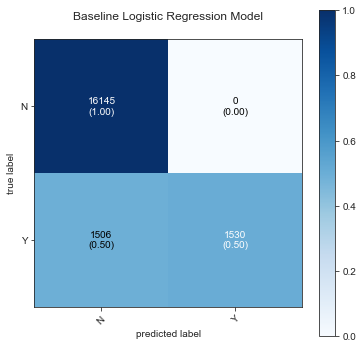

Wall time: 10min 5s


In [168]:
%%time
df = pd.read_csv("df.csv", index_col=[0]) 

y = df.QuoteUploaded
X = df.drop('QuoteUploaded', axis=1)

# split data into test/train dataset
X_train, X_test, y_train, y_test= train_test_split(X, y,                                                    
                                                   test_size=0.25,
                                                   random_state=0)
# scale data before training model
sc = StandardScaler()
# logistic regression model with default settings.
lrBaseLine = LogisticRegression(random_state = 0, 
                                solver='saga',
                                max_iter=1000)  

lrPipeBaseLine = make_pipeline(sc, lrBaseLine)
# run model and make predictions using test data
modelBaseLR = lrPipeBaseLine.fit(X_train, y_train)
y_pred_BaseLR = modelBaseLR.predict(X_test)
# prediction probabilities required for roc and precision recall curves
y_pred_prob_BaseLR = modelBaseLR.predict_proba(X_test)

# get scores and print results of model
cv_accuracy = cross_val_score(lrPipeBaseLine, X_train, y_train, scoring='accuracy', cv=kf)
cv_recall = cross_val_score(lrPipeBaseLine, X_train, y_train, scoring='recall', cv=kf)
cv_precision = cross_val_score(lrPipeBaseLine, X_train, y_train, scoring='precision', cv=kf)
cv_roc_auc = cross_val_score(lrPipeBaseLine, X_train, y_train, scoring='roc_auc', cv=kf)
printClassiferResults('Baseline Logistic Regression Model', y_test, y_pred_BaseLR, cv_recall,cv_roc_auc,cv_accuracy,cv_precision)
printConfusionMatrix('Baseline Logistic Regression Model', y_test, y_pred_BaseLR)

# roc and precision recall curves
fprbaseLR, tprbaseLR, _ = roc_curve(y_test, y_pred_prob_BaseLR[:,1], pos_label=1)
precbaseLR, recallbaseLR, _ = precision_recall_curve(y_test, y_pred_prob_BaseLR[:,1])


#### Optimum Model 

Optimum Logistic Regression Model
=== Cross Validation Score ===
Mean Accuracy Score:  0.8918181436583081
Mean Recall Score:  0.5526354172782845
Mean Precision Score:  0.695801563325959
Mean ROC_AUC Score:  0.821779167370833
=== Test Data Score ===
Test Accuracy Score: 0.8910380063604608
Test Recall Score: 0.553030303030303
Test Precision Score: 0.6961028192371476
Test ROC_AUC Score: 0.7538146250363655




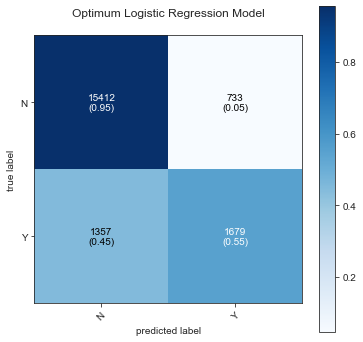

Wall time: 10min 31s


In [169]:
%%time
dfLR = pd.read_csv("dfLR.csv", index_col=[0]) 
# use reduced dataset
X = dfLR

X_train, X_test, y_train, y_test= train_test_split(X, y,                                                    
                                                   test_size=0.25,
                                                   random_state=0)

sc = StandardScaler()
lrOpt = LogisticRegression(random_state = 0, 
                           penalty = 'l2', 
                           C=11.513953993264458, 
                           solver='saga',
                           max_iter=10000,
                           class_weight='balanced')  
lrPipeOpt = make_pipeline(sc, lrOpt)

# run model and make predictions using test data
modelOptLR = lrPipeOpt.fit(X_train, y_train)
y_pred_OptLR = modelOptLR.predict(X_test)
# prediction probabilities required for roc and precision recall curves
y_pred_prob_OptLR = modelOptLR.predict_proba(X_test)

# get scores and print results of model
cv_accuracy = cross_val_score(lrPipeOpt, X_train, y_train, scoring='accuracy', cv=kf)
cv_recall = cross_val_score(lrPipeOpt, X_train, y_train, scoring='recall', cv=kf)
cv_precision = cross_val_score(lrPipeOpt, X_train, y_train, scoring='precision', cv=kf)
cv_roc_auc = cross_val_score(lrPipeOpt, X_train, y_train, scoring='roc_auc', cv=kf)
printClassiferResults('Optimum Logistic Regression Model', y_test, y_pred_OptLR, cv_recall,cv_roc_auc,cv_accuracy,cv_precision)
printConfusionMatrix('Optimum Logistic Regression Model', y_test, y_pred_OptLR)

# roc and precision recall curves
fprOptLR, tprOptLR, _ = roc_curve(y_test, y_pred_prob_OptLR[:,1], pos_label=1)
precOptLR, recallOptLR, _ = precision_recall_curve(y_test, y_pred_prob_OptLR[:,1])

### Random Forest
#### Baseline Model 

Baseline Random Forest Model
=== Cross Validation Score ===
Mean Accuracy Score:  0.9705432159609739
Mean Recall Score:  0.8571487826648176
Mean Precision Score:  0.9502655531718771
Mean ROC_AUC Score:  0.9764068325122803
=== Test Data Score ===
Test Accuracy Score: 0.9734633230801314
Test Recall Score: 0.8820816864295126
Test Precision Score: 0.9466242488511841
Test ROC_AUC Score: 0.9363644728214456




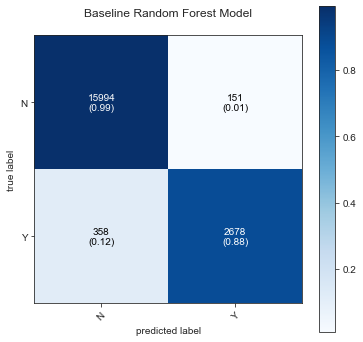

Wall time: 52.1 s


In [170]:
%%time
df = pd.read_csv("df.csv", index_col=[0]) 

y = df.QuoteUploaded
X = df.drop('QuoteUploaded', axis=1)

X_train, X_test, y_train, y_test= train_test_split(X, y,                                                    
                                                   test_size=0.25,
                                                   random_state=0)

#random forest base - default parameters
rfBaseLine = RandomForestClassifier(random_state=0, 
                                    n_jobs=-1)  
# run model and make predictions using test data
modelBaseRF = rfBaseLine.fit(X_train, y_train)
y_pred_BaseRF = modelBaseRF.predict(X_test)
# prediction probabilities required for roc and precision recall curves
y_pred_prob_BaseRF = modelBaseRF.predict_proba(X_test)

# get scores and print results of model
cv_accuracy = cross_val_score(rfBaseLine, X_train, y_train, scoring='accuracy', cv=kf)
cv_recall = cross_val_score(rfBaseLine, X_train, y_train, scoring='recall', cv=kf)
cv_precision = cross_val_score(rfBaseLine, X_train, y_train, scoring='precision', cv=kf)
cv_roc_auc = cross_val_score(rfBaseLine, X_train, y_train, scoring='roc_auc', cv=kf)
printClassiferResults('Baseline Random Forest Model', y_test, y_pred_BaseRF, cv_recall,cv_roc_auc,cv_accuracy,cv_precision)
printConfusionMatrix('Baseline Random Forest Model', y_test, y_pred_BaseRF)

# roc and precision recall curves
fprbaseRF, tprbaseRF, _ = roc_curve(y_test, y_pred_prob_BaseRF[:,1], pos_label=1)
precbaseRF, recallbaseRF, _ = precision_recall_curve(y_test, y_pred_prob_BaseRF[:,1])

#### Optimum Model 

Optimum Random Forest Model
=== Cross Validation Score ===
Mean Accuracy Score:  0.9706301301523483
Mean Recall Score:  0.8705158243002831
Mean Precision Score:  0.9378930142846116
Mean ROC_AUC Score:  0.9790007335375343
=== Test Data Score ===
Test Accuracy Score: 0.9732026484541995
Test Recall Score: 0.8903162055335968
Test Precision Score: 0.937239944521498
Test ROC_AUC Score: 0.9395526521628962




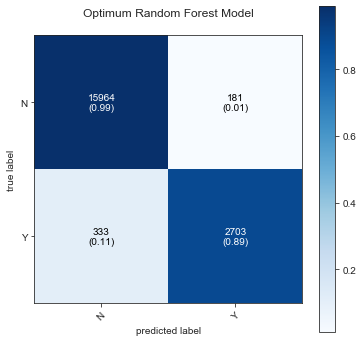

Wall time: 7min 12s


In [171]:
%%time
dfRF = pd.read_csv("dfRF.csv", index_col=[0]) 
X = dfRF
X_train, X_test, y_train, y_test= train_test_split(X, y,                                                    
                                                   test_size=0.25,
                                                   random_state=0)
# Oversample data to handle imbalanced dataset
ros = RandomOverSampler(random_state=0)
# hyper tuned parameters
rfOpt = RandomForestClassifier(random_state=0,
                               n_jobs=-1,
                               n_estimators=500,
                               min_samples_split=14,
                               min_samples_leaf=8,
                               max_features='auto',
                               max_depth=None,
                               criterion='entropy',
                               bootstrap=False
                           )

pipeOpt = make_pipeline(ros, rfOpt)
# run model and make predictions using test data
modelOptRF = pipeOpt.fit(X_train, y_train)
y_pred_OptRF = modelOptRF.predict(X_test)
# prediction probabilities required for roc and precision recall curves
y_pred_prob_OptRF = modelOptRF.predict_proba(X_test)

# get scores and print results of model
cv_accuracy = cross_val_score(pipeOpt, X_train, y_train, scoring='accuracy', cv=kf)
cv_recall = cross_val_score(pipeOpt, X_train, y_train, scoring='recall', cv=kf)
cv_precision = cross_val_score(pipeOpt, X_train, y_train, scoring='precision', cv=kf)
cv_roc_auc = cross_val_score(pipeOpt, X_train, y_train, scoring='roc_auc', cv=kf)
printClassiferResults('Optimum Random Forest Model', y_test, y_pred_OptRF, cv_recall,cv_roc_auc,cv_accuracy,cv_precision)
printConfusionMatrix('Optimum Random Forest Model', y_test, y_pred_OptRF)

# roc and precision recall curves
fprOptRF, tprOptRF, _ = roc_curve(y_test, y_pred_prob_OptRF[:,1], pos_label=1)
precOptRF, recallOptRF, _ = precision_recall_curve(y_test, y_pred_prob_OptRF[:,1])

### K Nearest Neighbour
#### Baseline Model 

Baseline K Nearest Neighbour Model
=== Cross Validation Score ===
Mean Accuracy Score:  0.9383580734227268
Mean Recall Score:  0.7505681881388122
Mean Precision Score:  0.8393276962934296
Mean ROC_AUC Score:  0.9364991211373235
=== Test Data Score ===
Test Accuracy Score: 0.9414524790156926
Test Recall Score: 0.7760210803689065
Test Precision Score: 0.8417291889960701
Test ROC_AUC Score: 0.874291122408052




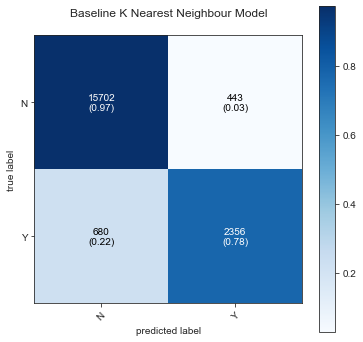

Wall time: 5min 32s


In [172]:
%%time
df = pd.read_csv("df.csv", index_col=[0]) 

y = df.QuoteUploaded
X = df.drop('QuoteUploaded', axis=1)

X_train, X_test, y_train, y_test= train_test_split(X, y,                                                    
                                                   test_size=0.25,
                                                   random_state=0)

sc = StandardScaler()
knnBaseLine = KNeighborsClassifier(n_jobs=-1)    
pipeBaseLine = make_pipeline(sc, knnBaseLine)
# run model and make predictions using test data
modelBaseKNN = pipeBaseLine.fit(X_train, y_train)
y_pred_BaseKNN = modelBaseKNN.predict(X_test)
# prediction probabilities required for roc and precision recall curves
y_pred_prob_BaseKNN = modelBaseKNN.predict_proba(X_test)

# get scores and print results of model
cv_accuracy = cross_val_score(pipeBaseLine, X_train, y_train, scoring='accuracy', cv=kf)
cv_recall = cross_val_score(pipeBaseLine, X_train, y_train, scoring='recall', cv=kf)
cv_precision = cross_val_score(pipeBaseLine, X_train, y_train, scoring='precision', cv=kf)
cv_roc_auc = cross_val_score(pipeBaseLine, X_train, y_train, scoring='roc_auc', cv=kf)
printClassiferResults('Baseline K Nearest Neighbour Model', y_test, y_pred_BaseKNN, cv_recall,cv_roc_auc,cv_accuracy,cv_precision)
printConfusionMatrix('Baseline K Nearest Neighbour Model', y_test, y_pred_BaseKNN)

# roc and precision recall curves
fprBaseKNN, tprBaseKNN, _ = roc_curve(y_test, y_pred_prob_BaseKNN[:,1], pos_label=1)
precBaseKNN, recallBaseKNN, _ = precision_recall_curve(y_test, y_pred_prob_BaseKNN[:,1])

#### Optimum Model 

Optimum K Nearest Neighbour Model
=== Cross Validation Score ===
Mean Accuracy Score:  0.9310242653695824
Mean Recall Score:  0.9132833836612919
Mean Precision Score:  0.7211003126577831
Mean ROC_AUC Score:  0.9364991211373235
=== Test Data Score ===
Test Accuracy Score: 0.9353526927688859
Test Recall Score: 0.932806324110672
Test Precision Score: 0.7321613236814891
Test ROC_AUC Score: 0.9343189254495756




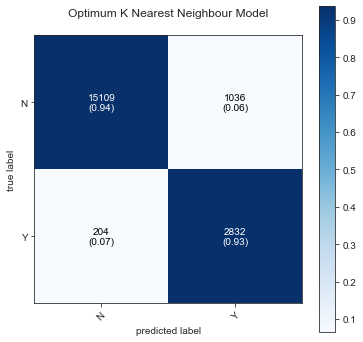

Wall time: 9min 33s


In [173]:
%%time
dfKNN = pd.read_csv("dfKNN.csv", index_col=[0]) 
X = dfKNN
X_train, X_test, y_train, y_test= train_test_split(X, y,                                                    
                                                   test_size=0.25,
                                                   random_state=0)
# Oversample data to handle imbalanced dataset
sc = StandardScaler()
ros = RandomOverSampler(random_state=0)
# hyper tuned parameters
knnOpt = KNeighborsClassifier(n_jobs=-1,
                             weights='distance',
                             n_neighbors=14,
                             leaf_size=3,
                             algorithm='kd_tree'                            
                           )

pipeOpt = make_pipeline(sc, ros, knnOpt)
# run model and make predictions using test data
modelOptKNN = pipeOpt.fit(X_train, y_train)
y_pred_OptKNN = modelOptKNN.predict(X_test)
# prediction probabilities required for roc and precision recall curves
y_pred_prob_OptKNN = modelOptKNN.predict_proba(X_test)

# get scores and print results of model
cv_accuracy = cross_val_score(pipeOpt, X_train, y_train, scoring='accuracy', cv=kf)
cv_recall = cross_val_score(pipeOpt, X_train, y_train, scoring='recall', cv=kf)
cv_precision = cross_val_score(pipeOpt, X_train, y_train, scoring='precision', cv=kf)
cv_accuracy = cross_val_score(pipeOpt, X_train, y_train, scoring='accuracy', cv=kf)
printClassiferResults('Optimum K Nearest Neighbour Model', y_test, y_pred_OptKNN, cv_recall,cv_roc_auc,cv_accuracy,cv_precision)
printConfusionMatrix('Optimum K Nearest Neighbour Model', y_test, y_pred_OptKNN)

# roc and precision recall curves
fprOptKNN, tprOptKNN, _ = roc_curve(y_test, y_pred_prob_OptKNN[:,1], pos_label=1)
precOptKNN, recallOptKNN, _ = precision_recall_curve(y_test, y_pred_prob_OptKNN[:,1])


### XGBoost Classifier
#### Baseline Model 

Baseline XGBoost Classifier
=== Cross Validation Score ===
Mean Accuracy Score:  0.9498800517118452
Mean Recall Score:  0.7020670049462974
Mean Precision Score:  0.9704410781097549
Mean ROC_AUC Score:  0.9573063459784097
=== Test Data Score ===
Test Accuracy Score: 0.9518273291277827
Test Recall Score: 0.7187088274044796
Test Precision Score: 0.9689165186500888
Test ROC_AUC Score: 0.8571865598775262




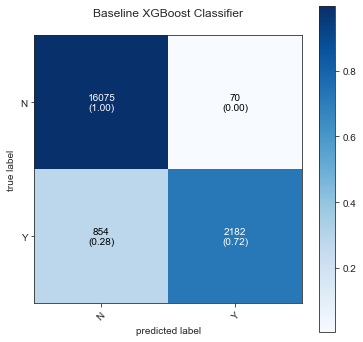

Wall time: 1min 10s


In [174]:
%%time

df = pd.read_csv("df.csv", index_col=[0]) 

y = df.QuoteUploaded
X = df.drop('QuoteUploaded', axis=1)

X_train, X_test, y_train, y_test= train_test_split(X, y,                                                    
                                                   test_size=0.25,
                                                   random_state=0)

xgbBaseLine = XGBClassifier(random_state=0, n_jobs=-1)   
# run model and make predictions using test data
modelBaseXGB = xgbBaseLine.fit(X_train, y_train)
y_pred_BaseXGB = modelBaseXGB.predict(X_test)
# prediction probabilities required for roc and precision recall curves
y_pred_prob_BaseXGB = modelBaseXGB.predict_proba(X_test)

# get scores and print results of model
cv_accuracy = cross_val_score(xgbBaseLine, X_train, y_train, scoring='accuracy', cv=kf)
cv_recall = cross_val_score(xgbBaseLine, X_train, y_train, scoring='recall', cv=kf)
cv_precision = cross_val_score(xgbBaseLine, X_train, y_train, scoring='precision', cv=kf)
cv_roc_auc = cross_val_score(xgbBaseLine, X_train, y_train, scoring='roc_auc', cv=kf)
printClassiferResults('Baseline XGBoost Classifier', y_test, y_pred_BaseXGB, cv_recall,cv_roc_auc,cv_accuracy,cv_precision)
printConfusionMatrix('Baseline XGBoost Classifier', y_test, y_pred_BaseXGB)

# roc and precision recall curves
fprBaseXGB, tprBaseXGB, _ = roc_curve(y_test, y_pred_prob_BaseXGB[:,1], pos_label=1)
precBaseXGB, recallBaseXGB, _ = precision_recall_curve(y_test, y_pred_prob_BaseXGB[:,1])


#### Optimum Model 

Optimum XGBoost Classifier Model
=== Cross Validation Score ===
Mean Accuracy Score:  0.9650689627160739
Mean Recall Score:  0.8199811379702229
Mean Precision Score:  0.9506672033543705
Mean ROC_AUC Score:  0.9708944472400802
=== Test Data Score ===
Test Accuracy Score: 0.9655909493769876
Test Recall Score: 0.8274044795783926
Test Precision Score: 0.9486404833836858
Test ROC_AUC Score: 0.9094904095011814




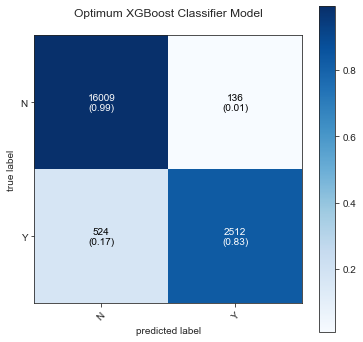

Wall time: 8min 2s


In [175]:
%%time
dfXGB = pd.read_csv("dfXGB.csv", index_col=[0]) 
X = dfXGB
X_train, X_test, y_train, y_test= train_test_split(X, y,                                                    
                                                   test_size=0.25,
                                                   random_state=0)
ros = RandomOverSampler(random_state=0)
# hyper tuned parameters
xgbOpt = XGBClassifier(random_state=0, 
                       n_jobs=-1, 
                       colsample_bytree=0.6948953189819347, 
                       learning_rate=0.09113090404327123,
                       max_depth=7,
                       min_child_weight=2,
                       n_estimators=700,
                       subsample=0.5000892494264289)   

pipeOpt = xgbOpt
# run model and make predictions using test data
modelOptXGB = pipeOpt.fit(X_train, y_train)
y_pred_OptXGB = modelOptXGB.predict(X_test)
# prediction probabilities required for roc and precision recall curves
y_pred_prob_OptXGB = modelOptXGB.predict_proba(X_test)

# get scores and print results of model
cv_accuracy = cross_val_score(pipeOpt, X_train, y_train, scoring='accuracy', cv=kf)
cv_recall = cross_val_score(pipeOpt, X_train, y_train, scoring='recall', cv=kf)
cv_precision = cross_val_score(pipeOpt, X_train, y_train, scoring='precision', cv=kf)
cv_roc_auc = cross_val_score(pipeOpt, X_train, y_train, scoring='roc_auc', cv=kf)
printClassiferResults('Optimum XGBoost Classifier Model', y_test, y_pred_OptXGB, cv_recall,cv_roc_auc,cv_accuracy,cv_precision)
printConfusionMatrix('Optimum XGBoost Classifier Model', y_test, y_pred_OptXGB)

# roc and precision recall curves
fprOptXGB, tprOptXGB, _ = roc_curve(y_test, y_pred_prob_OptXGB[:,1], pos_label=1)
precOptXGB, recallOptXGB, _ = precision_recall_curve(y_test, y_pred_prob_OptXGB[:,1])

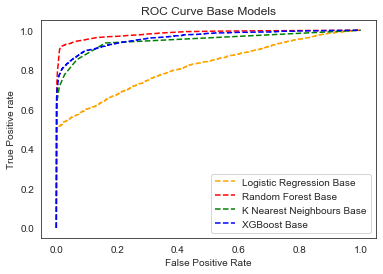

In [94]:
# source:  https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
# plot roc curves
plt.plot(fprbaseLR, tprbaseLR, linestyle='--',color='orange', label='Logistic Regression Base')
plt.plot(fprbaseRF, tprbaseRF, linestyle='--',color='red', label='Random Forest Base')
plt.plot(fprBaseKNN, tprBaseKNN, linestyle='--',color='green', label='K Nearest Neighbours Base')
plt.plot(fprBaseXGB, tprBaseXGB, linestyle='--',color='blue', label='XGBoost Base')

# title
plt.title('ROC Curve Base Models')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC_Base',dpi=300)
plt.show();

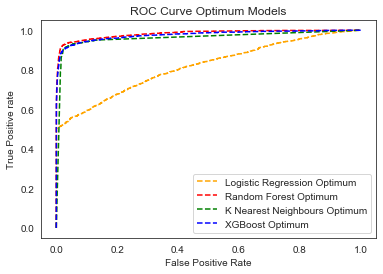

In [95]:
# Opt Curves (ROC)
# plot roc curves
plt.plot(fprOptLR, tprOptLR, linestyle='--',color='orange', label='Logistic Regression Optimum')
plt.plot(fprOptRF, tprOptRF, linestyle='--',color='red', label='Random Forest Optimum')
plt.plot(fprOptKNN, tprOptKNN, linestyle='--',color='green', label='K Nearest Neighbours Optimum')
plt.plot(fprOptXGB, tprOptXGB, linestyle='--',color='blue', label='XGBoost Optimum')

#plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC Curve Optimum Models')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC_Opt',dpi=300)
plt.show();

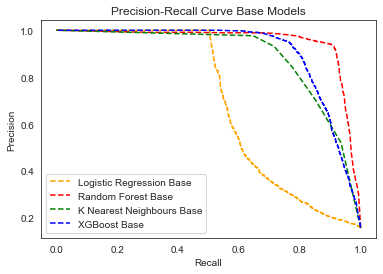

In [96]:
# Precision-Recall Curves - Base
# plot roc curves
plt.plot(recallbaseLR, precbaseLR, linestyle='--',color='orange', label='Logistic Regression Base')
plt.plot(recallbaseRF, precbaseRF, linestyle='--',color='red', label='Random Forest Base')
plt.plot(recallBaseKNN, precBaseKNN, linestyle='--',color='green', label='K Nearest Neighbours Base')
plt.plot(recallBaseXGB, precBaseXGB, linestyle='--',color='blue', label='XGBoost Base')

# title
plt.title('Precision-Recall Curve Base Models')
# x label
plt.xlabel('Recall')
# y label
plt.ylabel('Precision')

plt.legend(loc='best')
plt.savefig('RecallPrecision_Base',dpi=300)
plt.show();

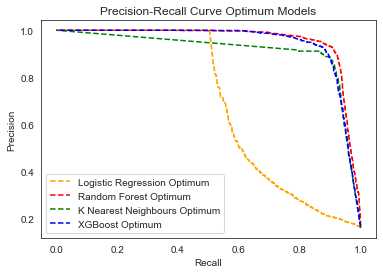

In [176]:
# Precision-Recall Curves - Optimum
# plot roc curves
plt.plot(recallOptLR, precOptLR, linestyle='--',color='orange', label='Logistic Regression Optimum')
plt.plot(recallOptRF, precOptRF, linestyle='--',color='red', label='Random Forest Optimum')
plt.plot(recallOptKNN, precOptKNN, linestyle='--',color='green', label='K Nearest Neighbours Optimum')
plt.plot(recallOptXGB, precOptXGB, linestyle='--',color='blue', label='XGBoost Optimum')

# title
plt.title('Precision-Recall Curve Optimum Models')
# x label
plt.xlabel('Recall')
# y label
plt.ylabel('Precision')

plt.legend(loc='best')
plt.savefig('RecallPrecision_Opt',dpi=300)
plt.show();